<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

### 2. To remove any houses that are not residential from the dataset. (Completed ahead of goal 1)

In [3]:
# Perform print to verify that there are data containing non-residential properties
# Remove houses that are not residential from the dataset
# Perform print to double-check that rows are removed properly
print(house['MSZoning'].unique())
house_residential = house[house['MSZoning'].str.contains("R")].copy()
print(house_residential['MSZoning'].unique())

print("A total of {} rows of non-residential data were dropped from the dataset.".format(len(house)-len(house_residential)))

['RL' 'RM' 'C (all)' 'FV' 'RH']
['RL' 'RM' 'RH']
A total of 75 rows of non-residential data were dropped from the dataset.


### 1. Perform any cleaning, feature engineering, and EDA you deem necessary.

#### A) CLEANING - To evaluate columns and address issue of null values
1 column and 8 rows were dropped during the data cleaning process.

In [4]:
# A significant portion (approx 20%) of Lot Frontage data is missing.
# In addition, as it is not a reasonable assumption for properties to have 0 Lot Frontage (i.e. no access to street),
# the entire column will be dropped from the dataframe instead and will not be employed in the modelling.

LotFrontage_null = house_residential['LotFrontage'].isnull().sum()/len(house_residential)
print("{}% of the Lot Frontage data is missing.".format(round(LotFrontage_null*100,2)))
house_residential.drop('LotFrontage',axis=1,inplace=True)

18.12% of the Lot Frontage data is missing.


In [5]:
# For MasVnrType and MasVnrArea columns, there are exactly 5 rows with missing data.
# Taking a look at the unique values, it is clear that the data for these 5 rows are omitted as opposed to being 'None'
# Decision is to drop these rows as (1) they represent a small data loss, and (2) it is not reasonable to make any 
# data assumption regarding these rows.

print(house_residential['MasVnrType'].unique())
print(house_residential[['MasVnrType','MasVnrArea']].isnull().sum())
house_residential.dropna(subset=['MasVnrType'],inplace=True) 

['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
MasVnrType    5
MasVnrArea    5
dtype: int64


In [6]:
# Columns 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature','BsmtQual','BsmtCond'
# Investigating NaN values in the above columns, there were no 'None values, and it is highly unlikely that None was read as NaN.
# Hence, to fill NaN values in these columns with 'NA' to indicate the absence of the feature None.

list_fillna =  ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature','BsmtQual','BsmtCond']

for column in list_fillna:
    house_residential[column].fillna('NA',inplace=True)

In [7]:
# For BsmtExposure, BsmtFinType2 columns, there are two rows with a 'Gd' basement.
# This implies that there are missing values for these observations, and since it is unfair to make an arbitrary assumption,
# These 2 rows will be dropped.

list_droprow = ['BsmtExposure','BsmtFinType2']

for column in list_droprow:
    house_residential.drop(house_residential[(house_residential[column].isnull()) & \
                        (house_residential['BsmtQual'] == 'Gd')].index,inplace=True)

# For BsmtExposure, BsmtFinType1, BsmtFinType2 columns
# Most of the missing values is due to the fact that there are no basement, hence a 'NA' will be filled for these columns. 
list_fillna = ['BsmtExposure','BsmtFinType1','BsmtFinType2']

for column in list_fillna:
    house_residential[column].fillna('NA',inplace=True)

In [8]:
# Column Electrical with null values will be dropped since it is unfair to make an arbitrary assumption
# 1 row total
house_residential.dropna(subset=['Electrical'],inplace=True) 

In [9]:
# For Garage-related rows, investigation shows that the null value is due to the fact that there is no Garage.
# Hence, a "NA" value will be filled for these columns.

garage_col = [col for col in list(house_residential.columns) if "Garage" in col]
house_residential[house_residential.isnull().any(axis=1)][garage_col].sum()

for column in garage_col:
    house_residential[column].fillna('NA',inplace=True)

#### B) FEATURE ENGINEERING & EDA - To perform preliminary EDA on the clean dataset - with fixed features only
The following steps were taken in preparation of the EDA: <br>
1) To perform feature engineering for MoSold and YrSold attributes into a *Period* column. <br>
2) Each attribute was classified according to whether they were *fixed* or *variable*. <br>
3) For each fixed variable, their data type was identified: *categorical* or *continuous*. <br>
<br>
There will be **no need** to select relevant predictor variables as a Lasso algorithm will be deployed in predicting sale price.<br>
A Lasso algorithm will also help in identifying the relevant predictors out of the 30 possible fixed variables. And it will be a more rigorous approach than running a linear regression algorithm with predictor variables manually selected by users based on contextual knowledge, pearson & spearman correlation, and forward selection (a greedier approach to modelling).

In [10]:
# Classification of attributes into fixed/variable, and categorical/continuous by analyzing the data description.

fixed_cat = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','LotConfig', \
                  'LandSlope','Neighborhood','BldgType','HouseStyle',\
                  'Foundation','BsmtQual','BsmtExposure','GarageType','SaleType','SaleCondition']

fixed_cont = ['LotArea','TotalBsmtSF','1stFlrSF','2ndFlrSF','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',\
                'BedroomAbvGr','KitchenAbvGr','Fireplaces','GarageCars','GarageArea']
        
print("In total, there are {} possible fixed predictor variables.".format(len(fixed_cat)+len(fixed_cont)))

In total, there are 30 possible fixed predictor variables.


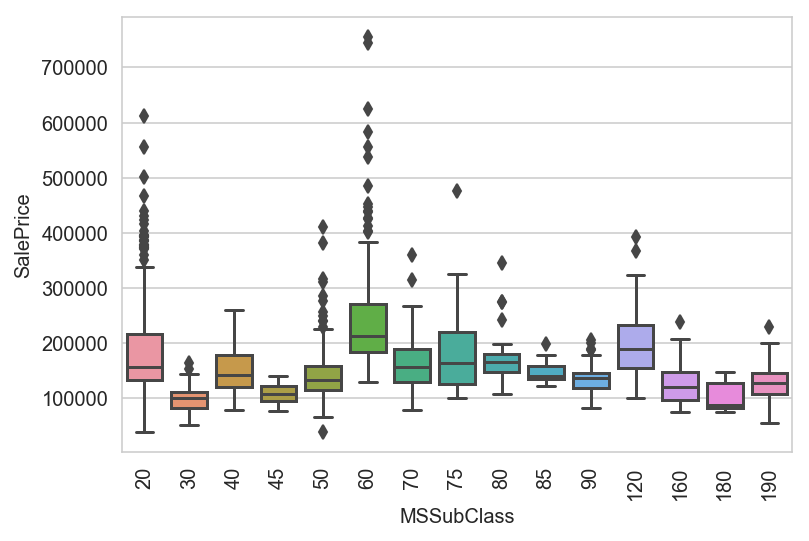

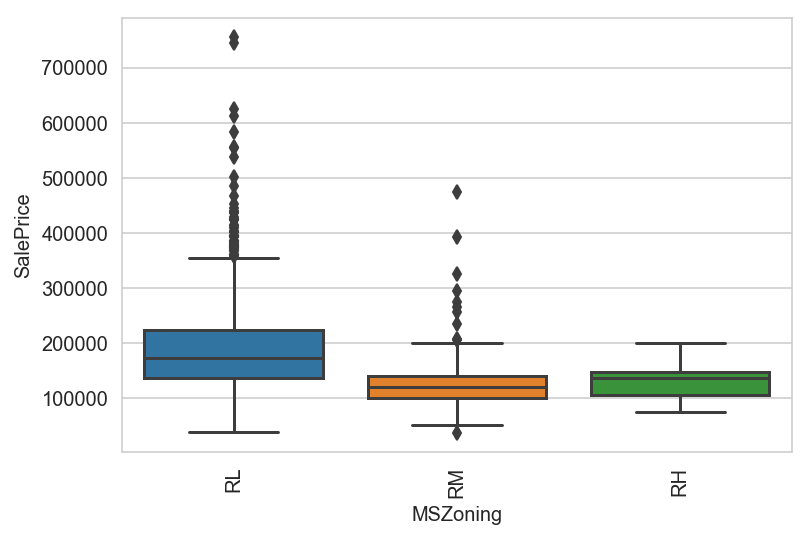

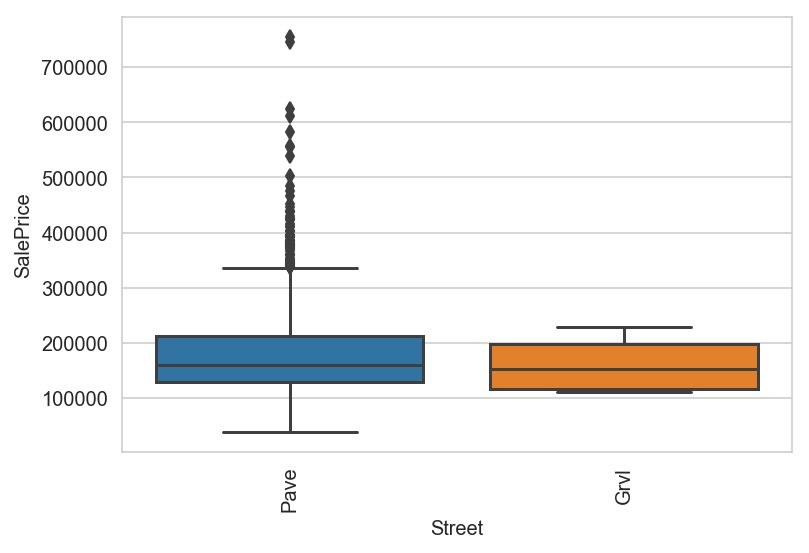

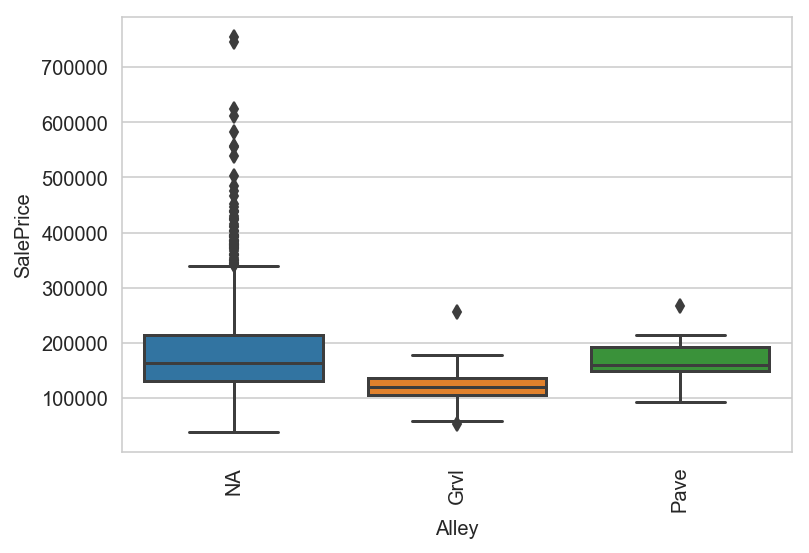

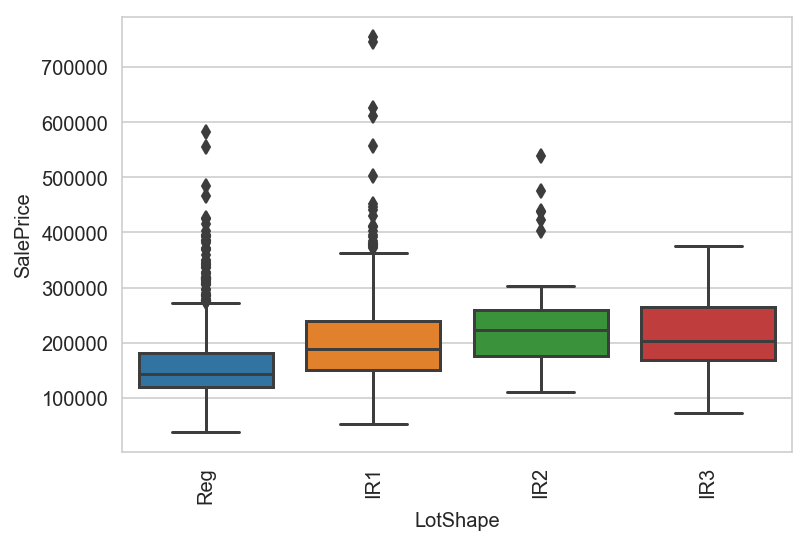

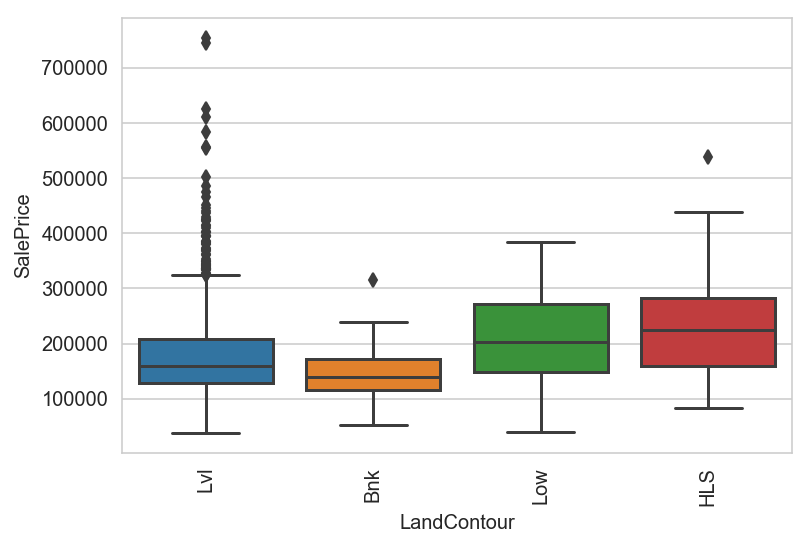

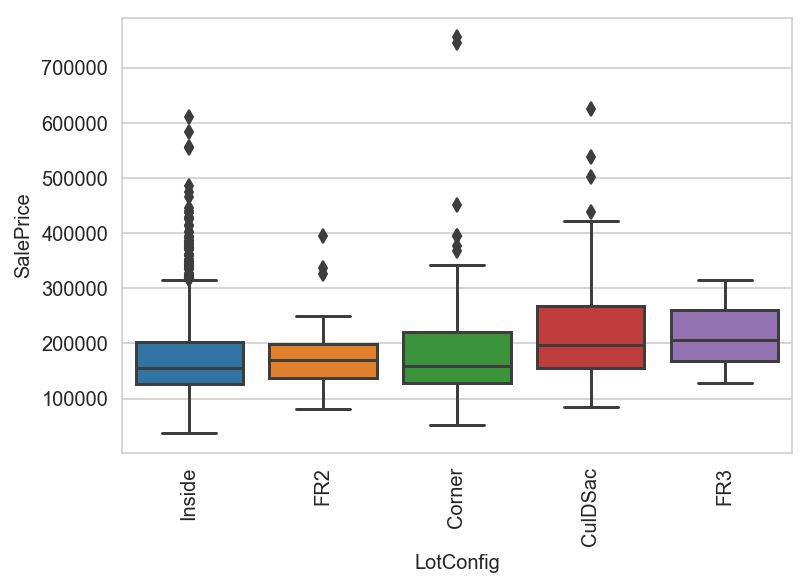

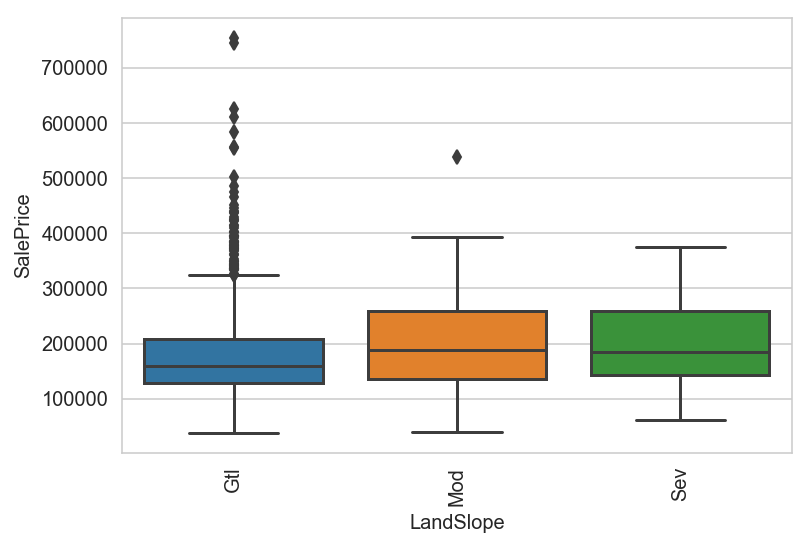

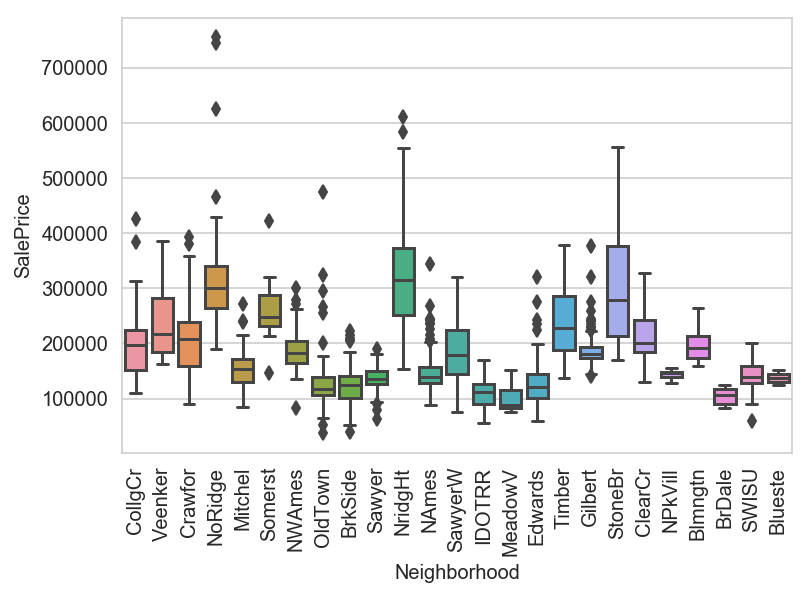

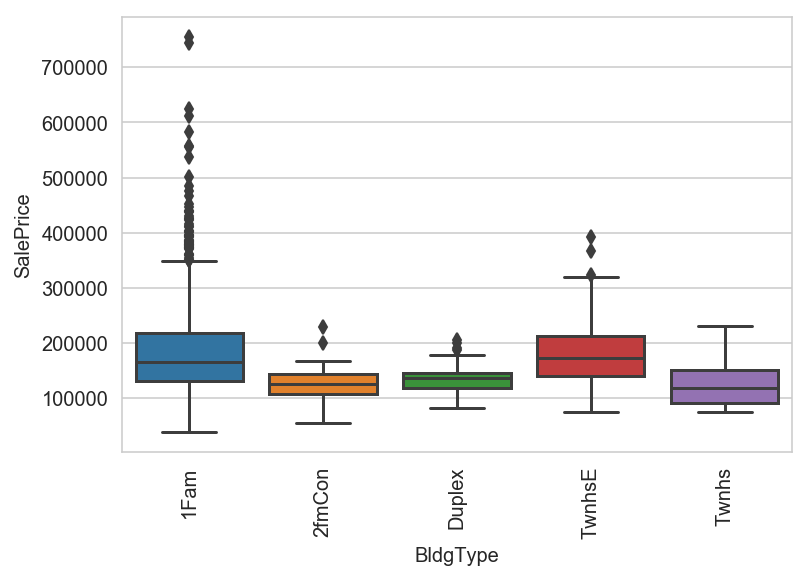

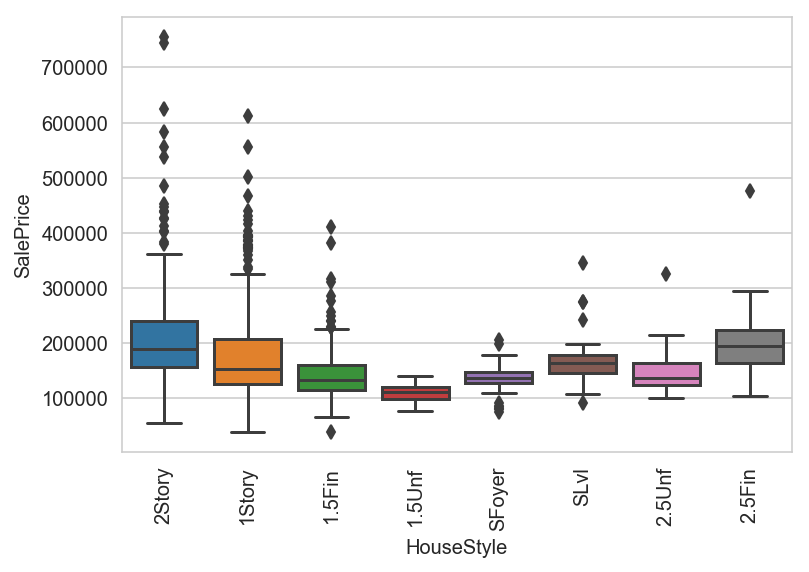

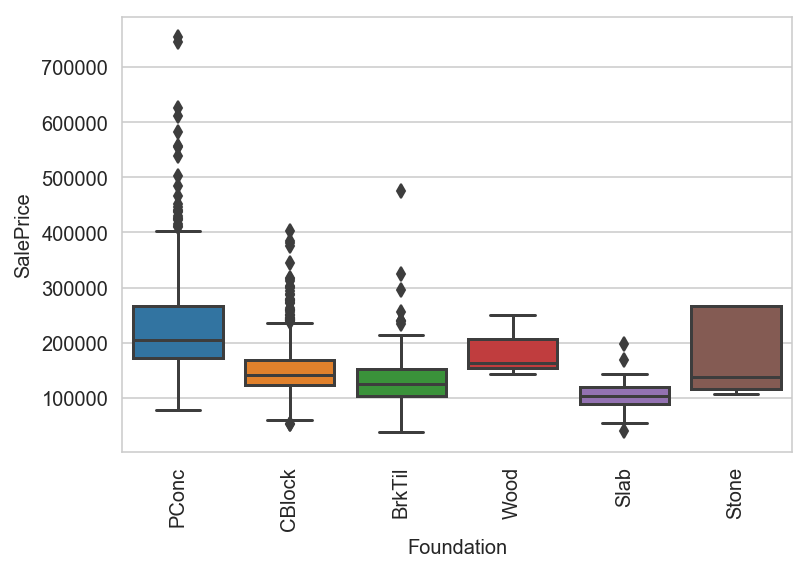

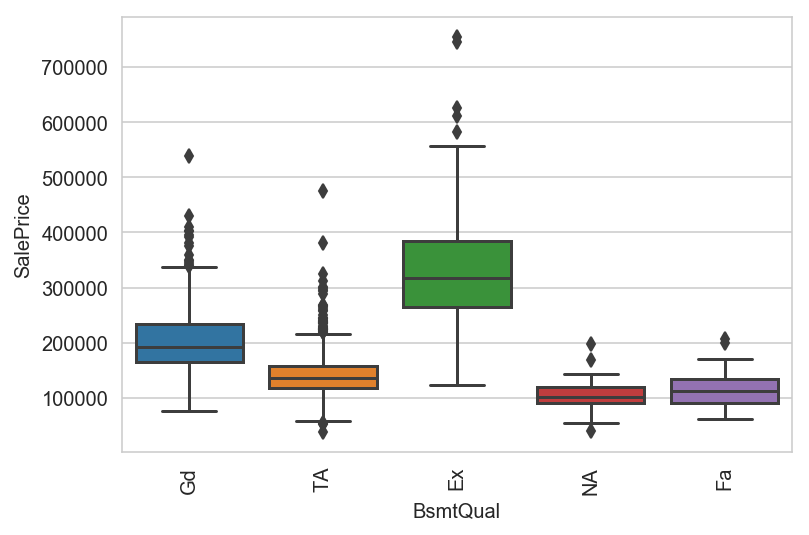

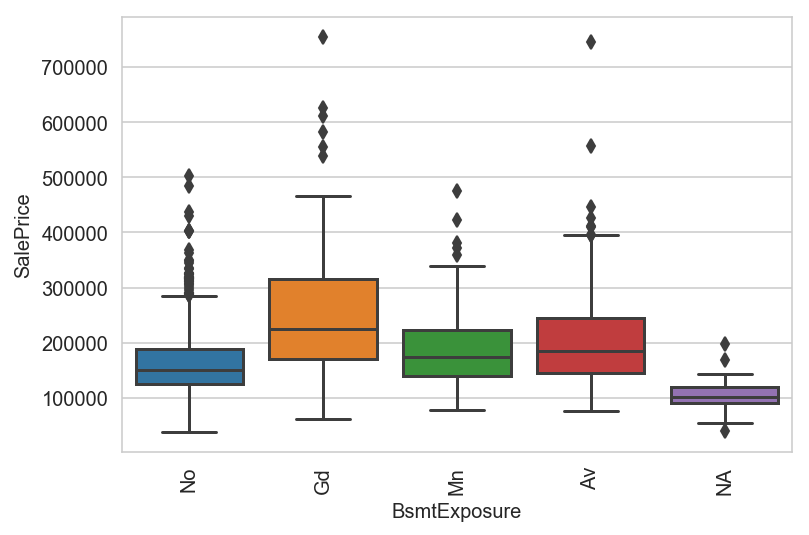

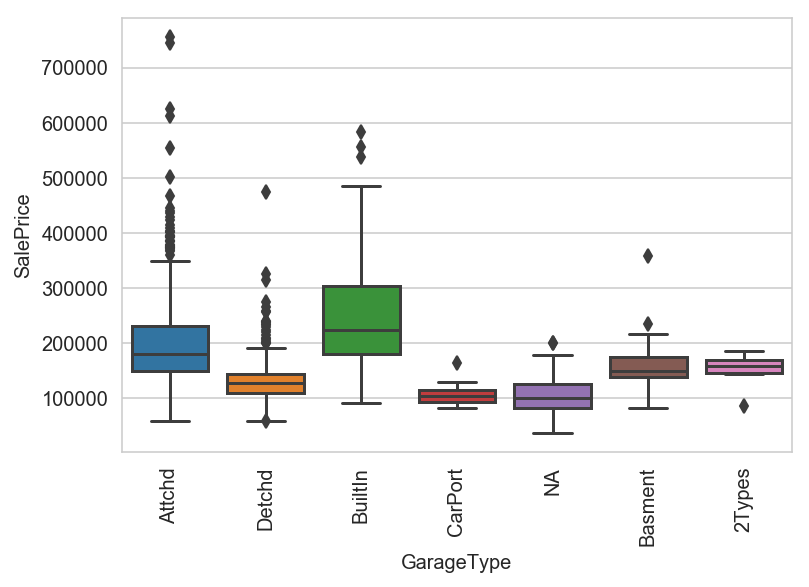

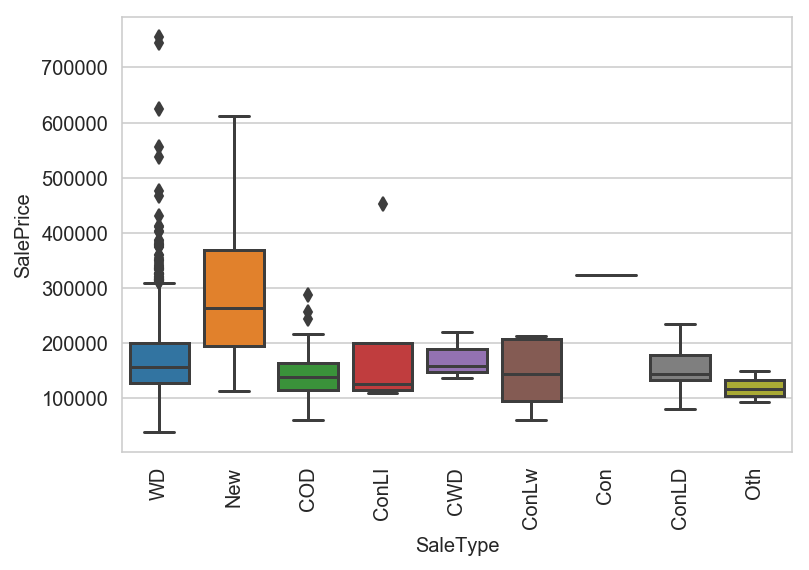

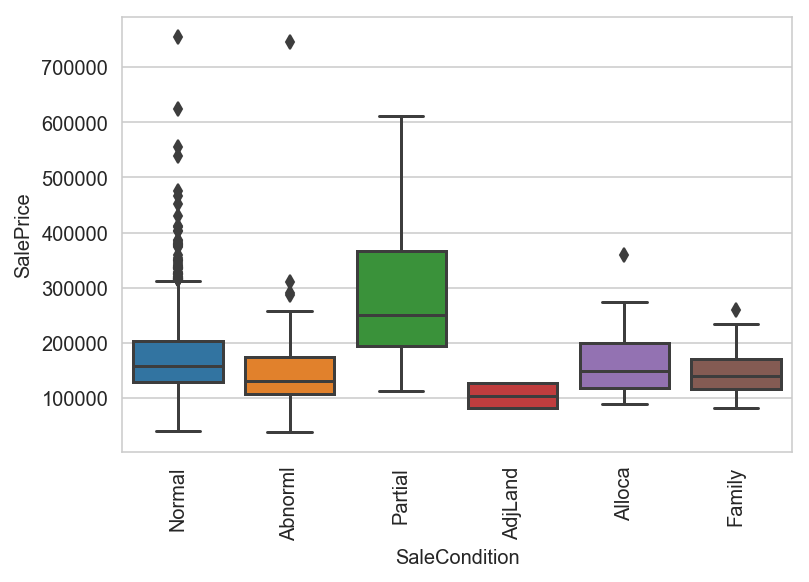

In [11]:
# To analyze all fixed categorical variables

# Configure style of seaborn to one with grids
sns.set_style("whitegrid")

# Loop through column list to plot boxplot for visual inspection and rough understanding of data
for column in fixed_cat:
    plt.figure()
    plt.xticks(rotation=90)
    sns.boxplot(house_residential[column],house_residential['SalePrice'])

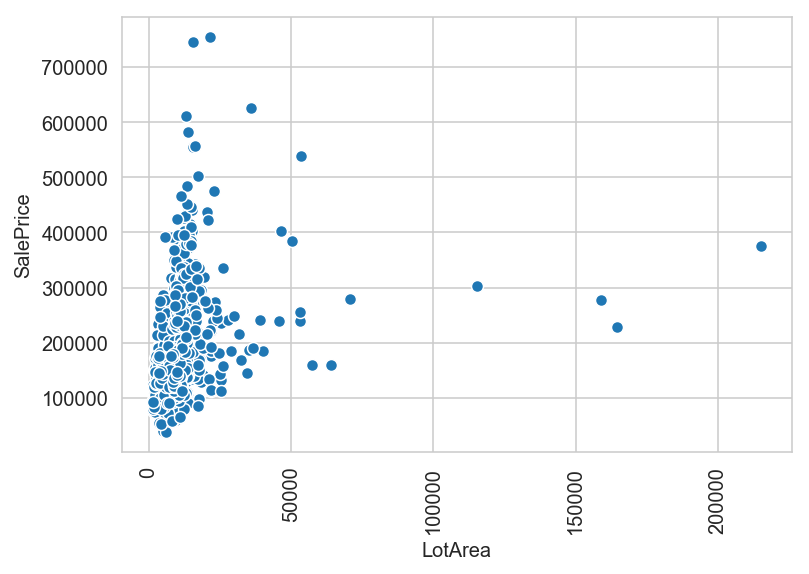

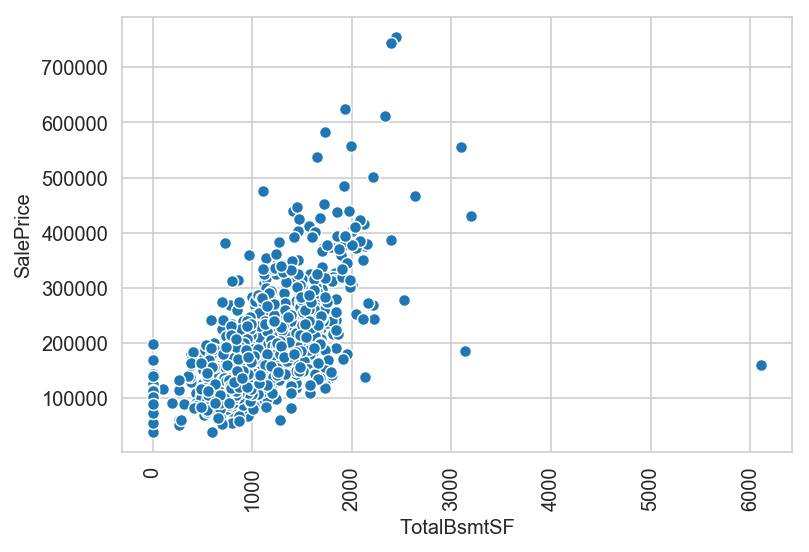

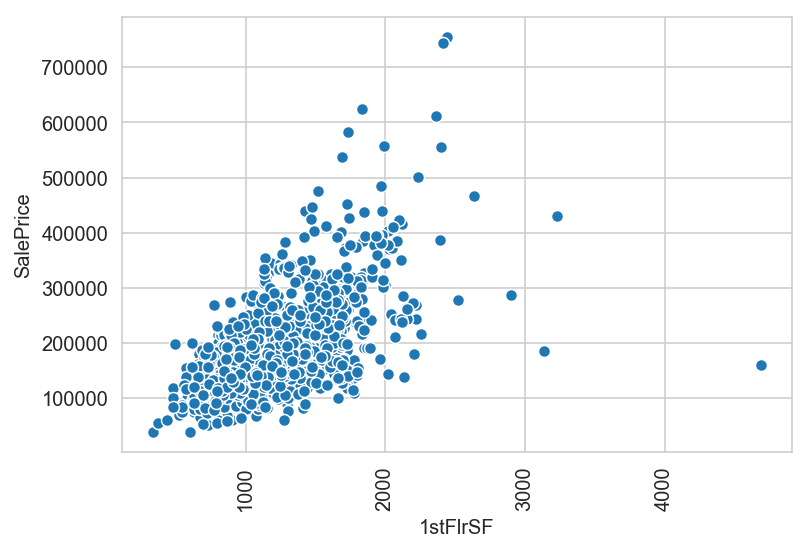

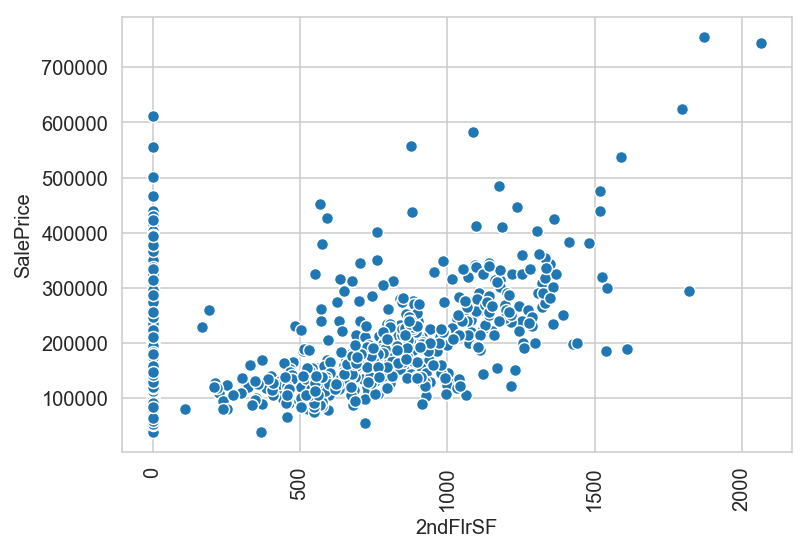

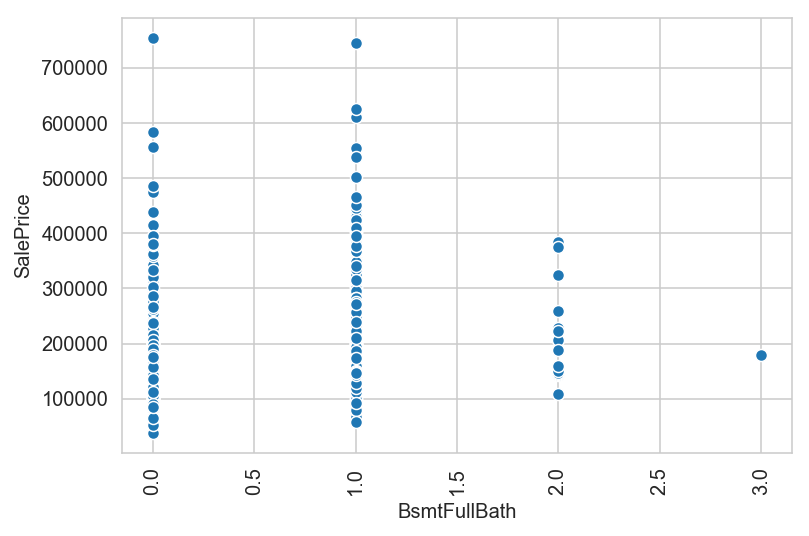

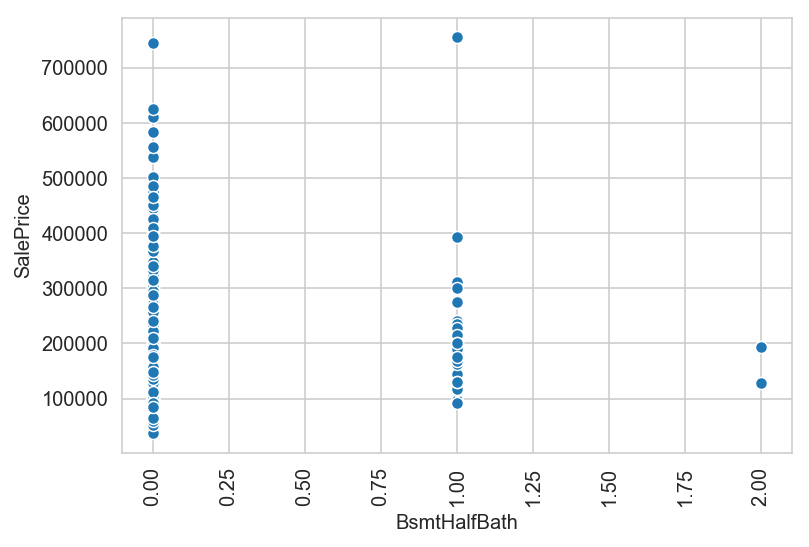

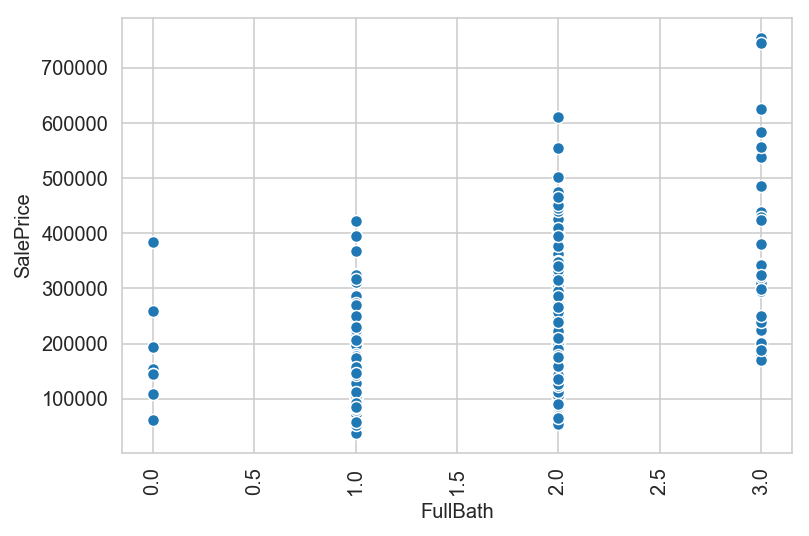

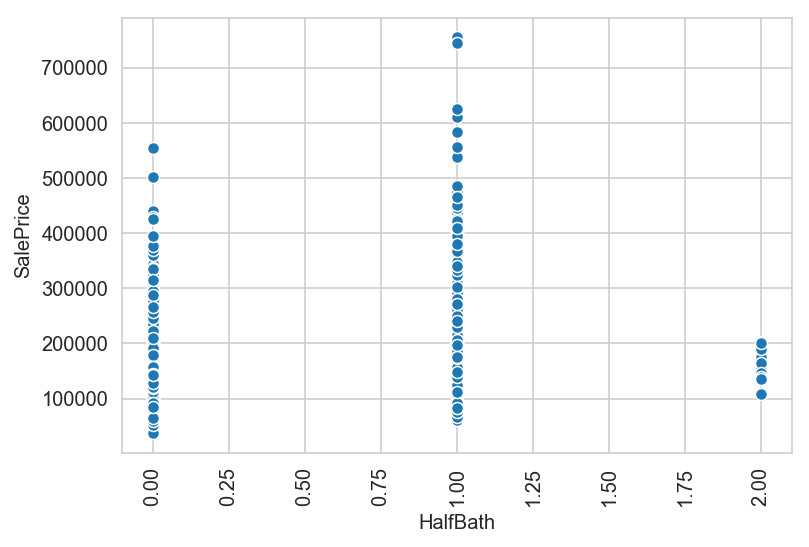

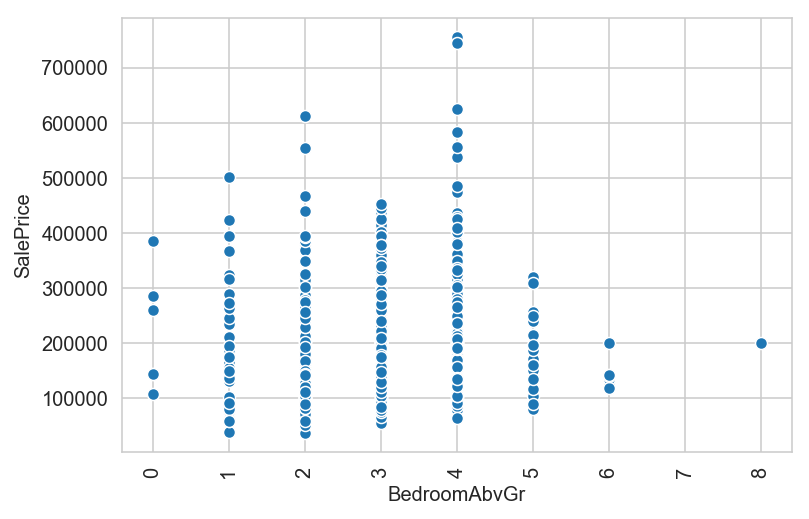

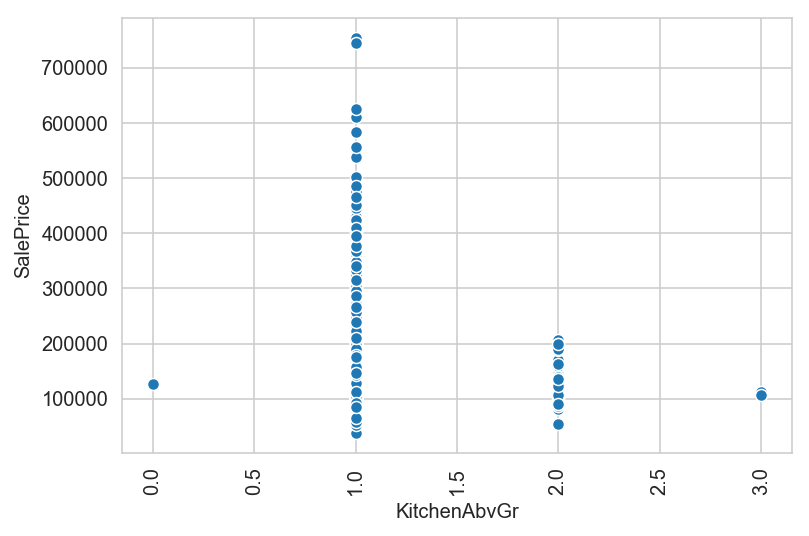

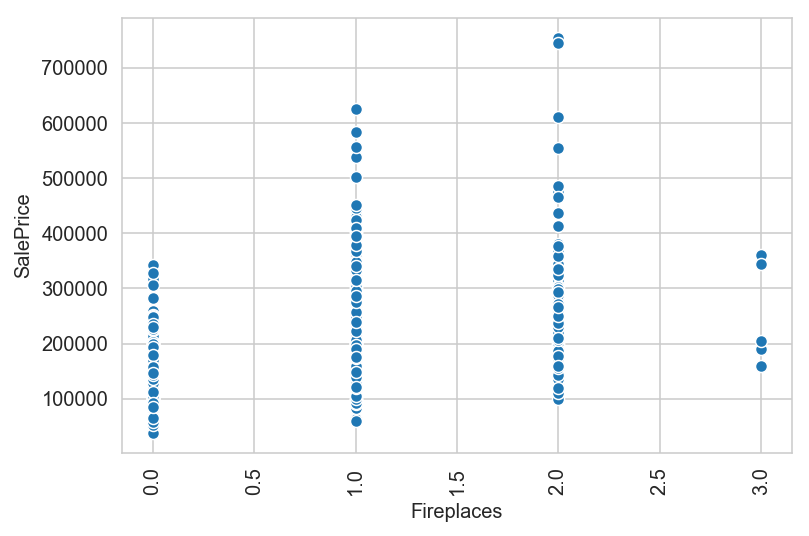

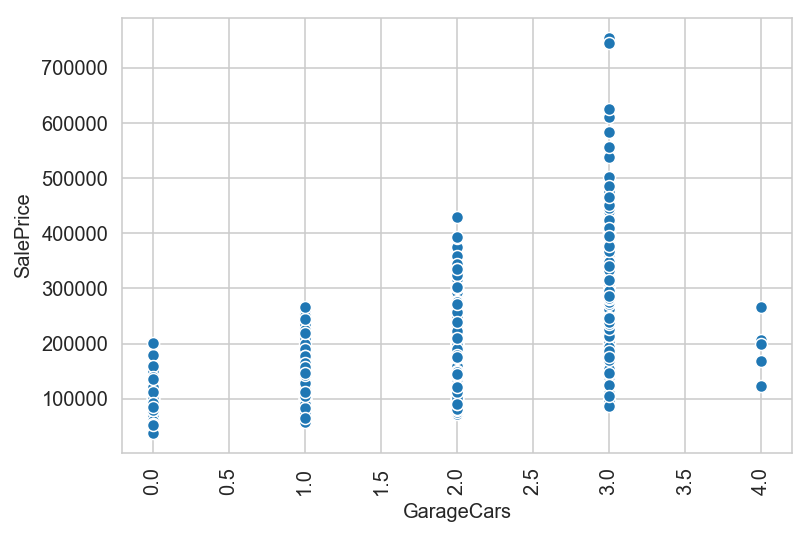

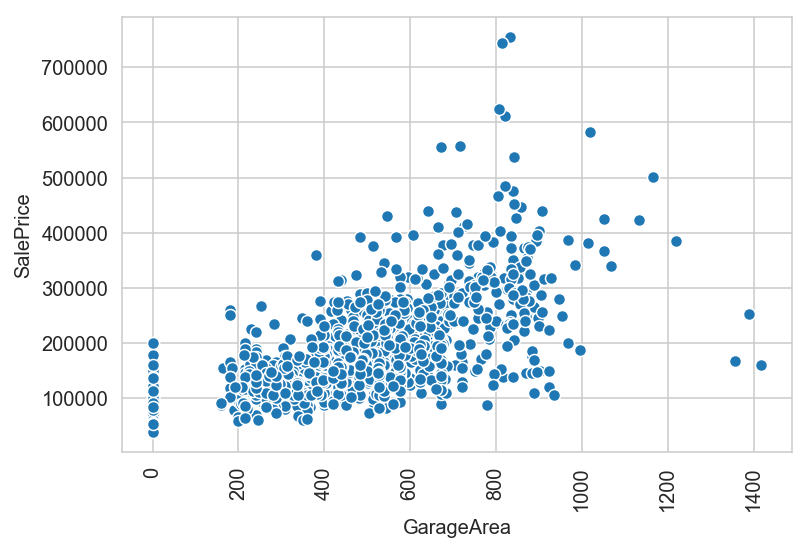

In [12]:
# To analyze all fixed continuous variables

# Loop through column list to plot boxplot for visual inspection and rough understanding of data
for column in fixed_cont:
    plt.figure()
    plt.xticks(rotation=90)
    sns.scatterplot(house_residential[column],house_residential['SalePrice'])

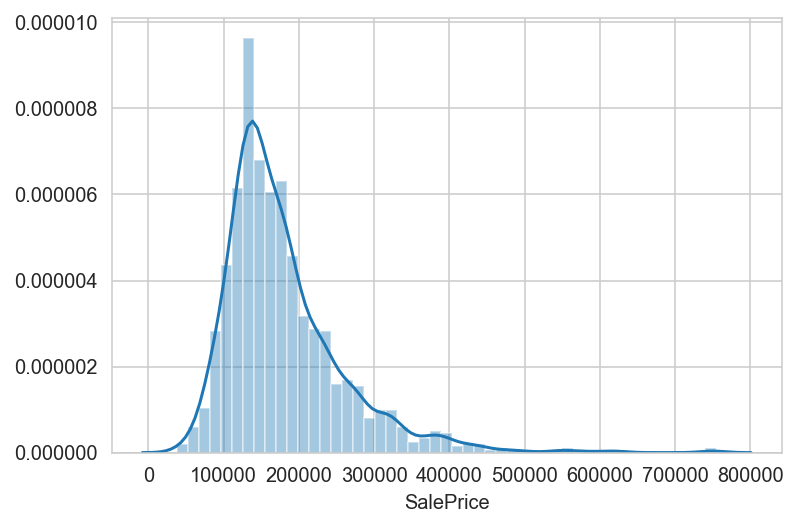

In [13]:
sns.distplot(house_residential['SalePrice'])

### 3) Identify fixed features that can predict price.

From the EDA, all potential fixed features have been cleansed and prepped for modelling. As mentioned earlier, the use of Lasso will help identify the features that can predict price. Below are steps to prepare train/test set, and also convert dummy variables accordingly.

In [14]:
# Convert categorical variables into dummy variables for regression
# Split data into two datasets: pre-2010 and 2010

house_residential['MSSubClass'] = house_residential['MSSubClass'].astype('object')
fixed_pred_var = fixed_cont + fixed_cat + ['YrSold']
predict_var = house_residential[fixed_pred_var].copy()
target_var = house_residential['SalePrice']

full_col_predict_var = pd.get_dummies(predict_var).columns
predict_var = pd.get_dummies(predict_var,drop_first=True)

predict_var_train = predict_var[predict_var['YrSold'] < 2010].drop('YrSold',axis=1)
predict_var_test = predict_var[predict_var['YrSold'] == 2010].drop('YrSold',axis=1)
target_var_train = house_residential[house_residential['YrSold'] < 2010]['SalePrice']
target_var_test = house_residential[house_residential['YrSold'] == 2010]['SalePrice']

In [15]:
# Saving the reference baseline basis first dummy column dropped for all categorical variables
dummy_col = [col for col in full_col_predict_var if col not in predict_var]
print(dummy_col)

['MSSubClass_20', 'MSZoning_RH', 'Street_Grvl', 'Alley_Grvl', 'LotShape_IR1', 'LandContour_Bnk', 'LotConfig_Corner', 'LandSlope_Gtl', 'Neighborhood_Blmngtn', 'BldgType_1Fam', 'HouseStyle_1.5Fin', 'Foundation_BrkTil', 'BsmtQual_Ex', 'BsmtExposure_Av', 'GarageType_2Types', 'SaleType_COD', 'SaleCondition_Abnorml']


### 4) Train a model on pre-2010 data and evaluate its performance on the 2010 houses.

#### A) Train lasso model using pre-2010 data + optimize alpha hyperparameter

In [16]:
# Setting up hyperparameters for model
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import cross_val_score

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1,normalize=True)
optimal_lasso.fit(predict_var_train, target_var_train)
print("The optimal alpha for the lasso model is: {}.".format(optimal_lasso.alpha_))

lasso = Lasso(alpha=optimal_lasso.alpha_,normalize=True)
lasso_scores = cross_val_score(lasso,predict_var_train,target_var_train,cv=10)

print(lasso_scores,np.mean(lasso_scores))

lasso.fit(predict_var_train,target_var_train)
lasso_coefs = pd.DataFrame({'pred_var':predict_var_train.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef',inplace=True,ascending=False)

print('Percent variables zeroed out: {}%'.format(np.sum((lasso.coef_ == 0))/float(len(lasso.coef_))*100))
lasso_coefs.head()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

The optimal alpha for the lasso model is: 11.31137184846792.
[0.88757931 0.83491899 0.85042211 0.75112554 0.84092255 0.84730631
 0.88701024 0.80353909 0.53930639 0.83783747] 0.8079968000497499
Percent variables zeroed out: 24.324324324324326%


pred_var          coef      abs_coef
58  Neighborhood_NoRidge  71964.671283  71964.671283
65  Neighborhood_StoneBr  67838.967861  67838.967861
59  Neighborhood_NridgHt  58369.972609  58369.972609
99          SaleType_Con  42969.682321  42969.682321
84           BsmtQual_Fa -41984.225280  41984.225280

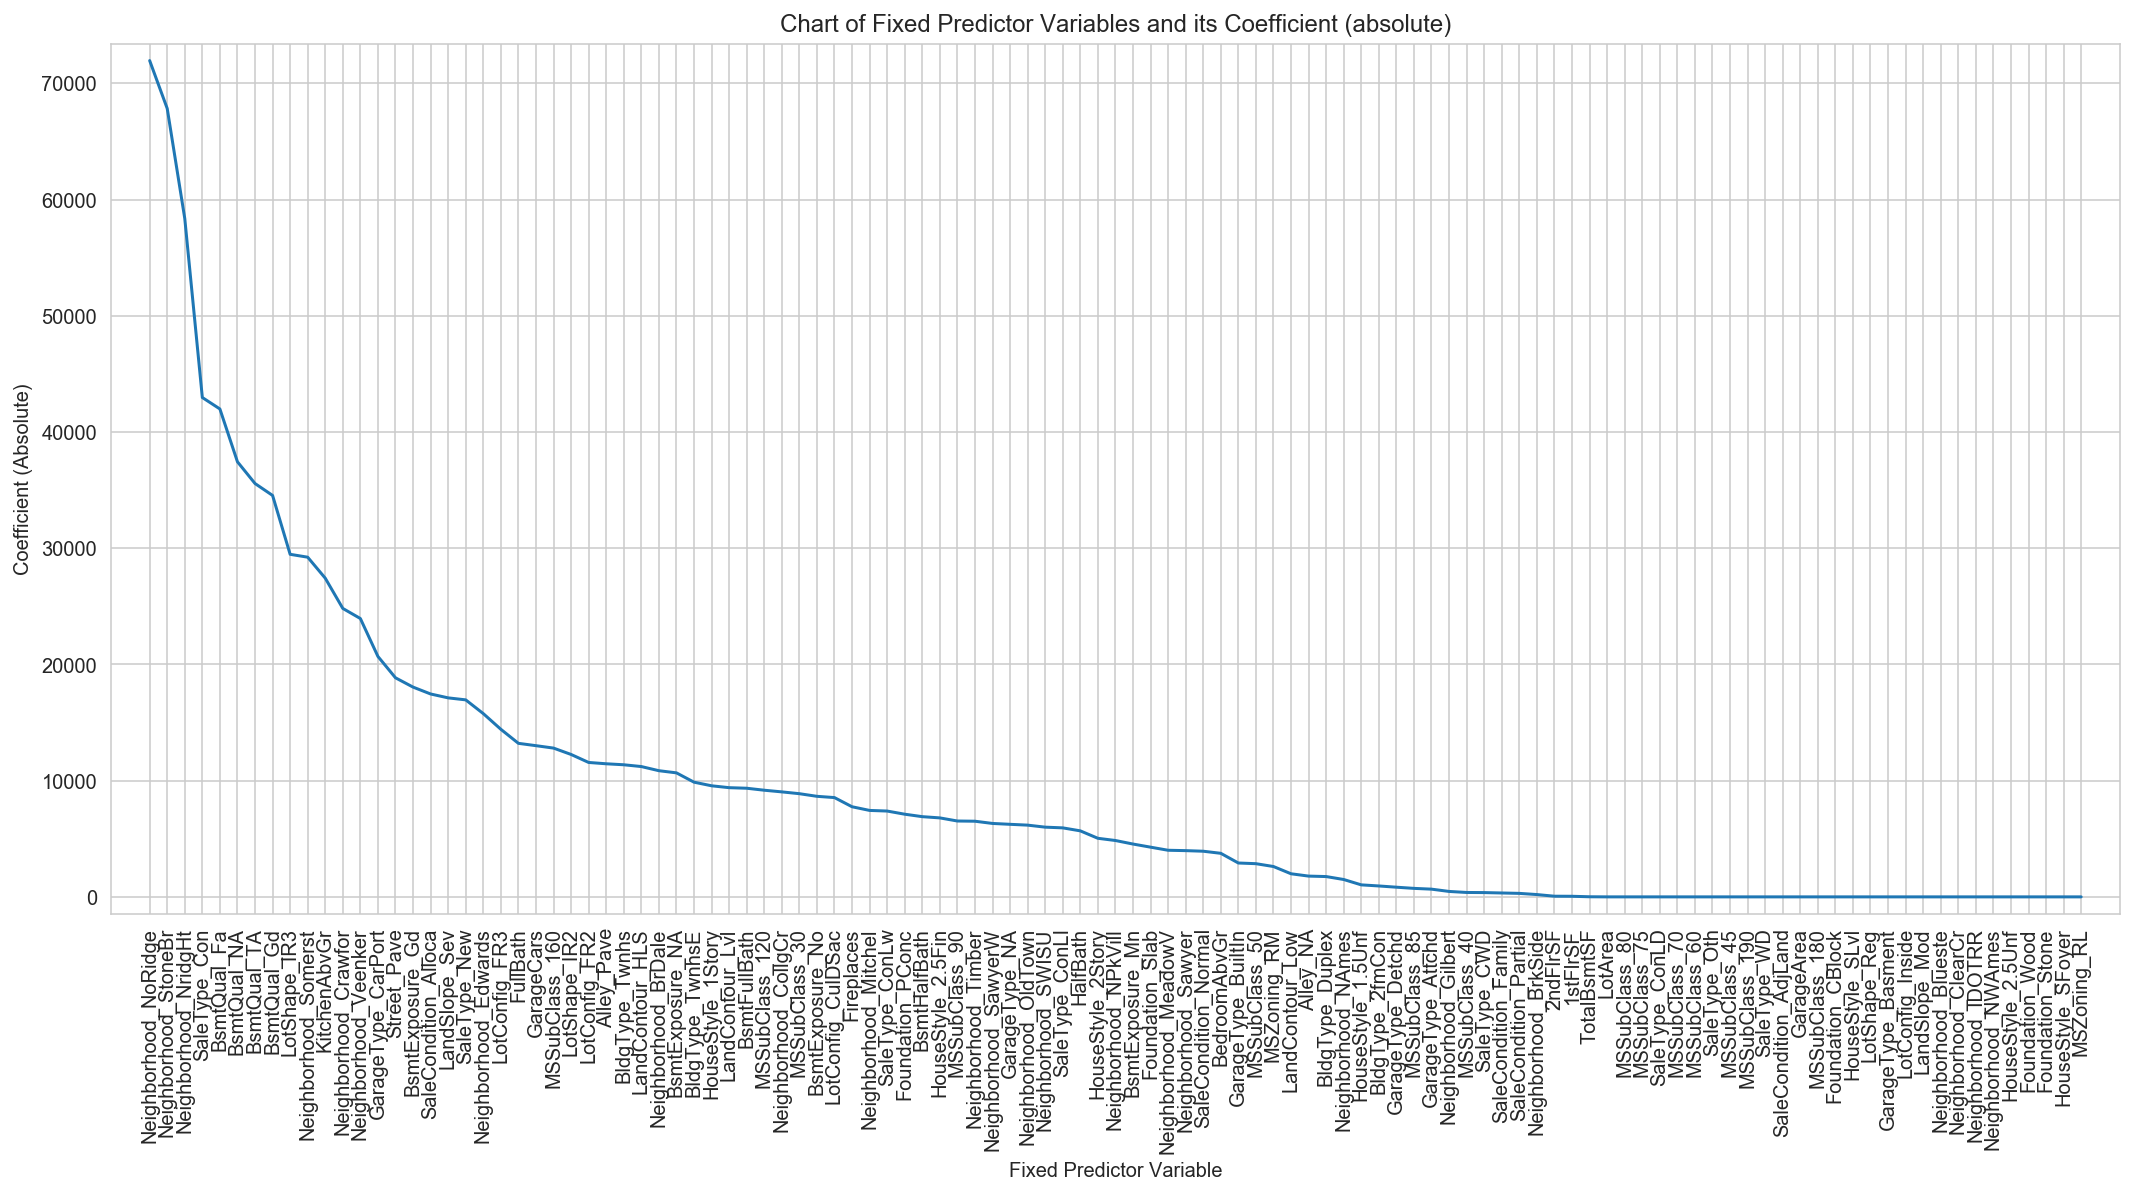

In [17]:
# Plot the coefficients
plt.figure(figsize=(18,8))
plt.plot(range(len(lasso.coef_)), lasso_coefs['abs_coef'])
plt.xticks(range(len(lasso.coef_)), lasso_coefs['pred_var'], rotation=90)
plt.title('Chart of Fixed Predictor Variables and its Coefficient (absolute)')
plt.xlabel('Fixed Predictor Variable')
plt.ylabel('Coefficient (Absolute)')
plt.margins(0.02)
plt.show()

<font color='blue'>**Based on the lasso results, the fixed features that can predict sale price are the ones with a coefficient that is not 0.**</font>

#### B) Evaluate its performance on the 2010 houses

In [18]:
test_score = lasso.score(predict_var_test,target_var_test)

print("The R-squared score for the 2010 houses is: {}.".format(test_score))
print("This is a good score as it explains approximately {}% of the variance in the target variable from its mean.".format(int(test_score*100)))

The R-squared score for the 2010 houses is: 0.865724654445264.
This is a good score as it explains approximately 86% of the variance in the target variable from its mean.


In [19]:
non_zero = lasso_coefs[lasso_coefs['abs_coef']!=0].copy()

non_zero['prefix'] = [row.split("_")[0] for row in non_zero['pred_var']]
coef_impt = non_zero.groupby(['prefix'], sort=True)['abs_coef'].max()

print("There are {} relevant fixed predictor variables.\n".format(len(coef_impt)))
print("The top 10 most relevant predictor variables are: ")
coef_impt.sort_values(ascending=False).head(10)

There are 29 relevant fixed predictor variables.

The top 10 most relevant predictor variables are: 


prefix
Neighborhood     71964.671283
SaleType         42969.682321
BsmtQual         41984.225280
LotShape         29477.600659
KitchenAbvGr     27423.806075
GarageType       20688.355000
Street           18851.411207
BsmtExposure     18050.796254
SaleCondition    17459.422066
LandSlope        17124.227918
Name: abs_coef, dtype: float64

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

### EDA on changeable predictor variable

In [119]:
# First step is to identify all possible predictor variables (fixed + changeable)

irrelevant_col = ['Id','MoSold','SalePrice']
all_pred_var = [col for col in house_residential.columns if col not in irrelevant_col]
var_pred_var = [col for col in house_residential.columns if (col not in irrelevant_col) and (col not in fixed_pred_var)]

# <font color='red'> Combined modification to address imbalance in categorical variables</font>

In [124]:
con1 = list(house_residential['Condition1'].unique())
con2 = list(house_residential['Condition2'].unique())
con_unique = list(set(con1 + con2))

con_unique = ["Condition_"+col for col in con_unique]

ext1 = list(house_residential['Exterior1st'].unique())
ext2 = list(house_residential['Exterior2nd'].unique())
ext_unique = list(set(ext1 + ext2))

ext_unique = ["Exterior_"+col for col in ext_unique]

for col in con_unique:
    condition = col.split("_")[1]
    house_residential[col] = house_residential['Condition1'].apply(lambda x: int(x == condition)) | \
                                    house_residential['Condition2'].apply(lambda x: int(x == condition))
    
for col in ext_unique:
    condition = col.split("_")[1]
    house_residential[col] = house_residential['Exterior1st'].apply(lambda x: int(x == condition)) | \
                                    house_residential['Exterior2nd'].apply(lambda x: int(x == condition))
    

In [127]:
irrelevant_col = ['Id','MoSold','SalePrice','Condition1','Condition2','Exterior1st','Exterior2nd']
all_pred_var = [col for col in house_residential.columns if col not in irrelevant_col]

In [21]:
var_cat = house_residential[var_pred_var].select_dtypes(include=['object']).columns
var_cont = house_residential[var_pred_var].select_dtypes(exclude=['object']).columns 

C:\Users\gohch\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


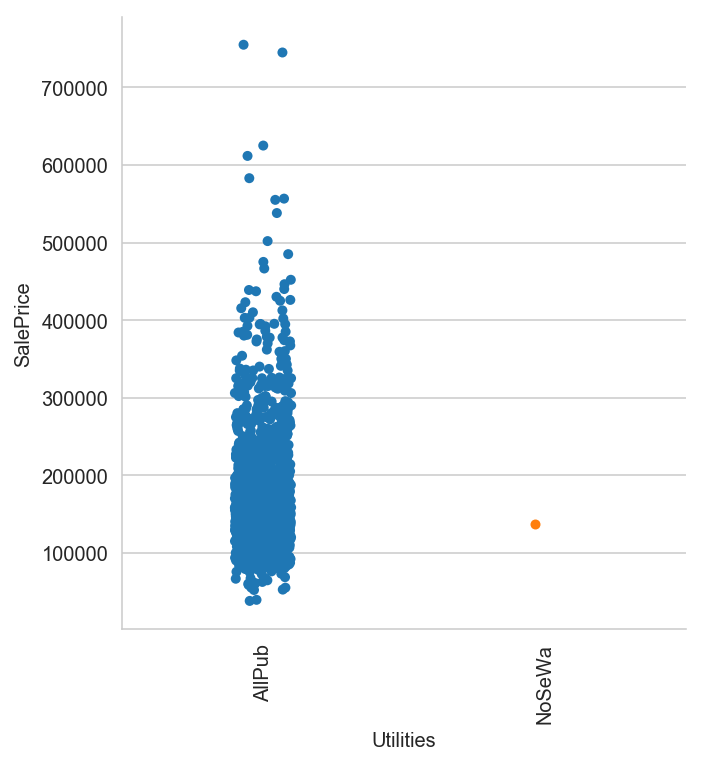

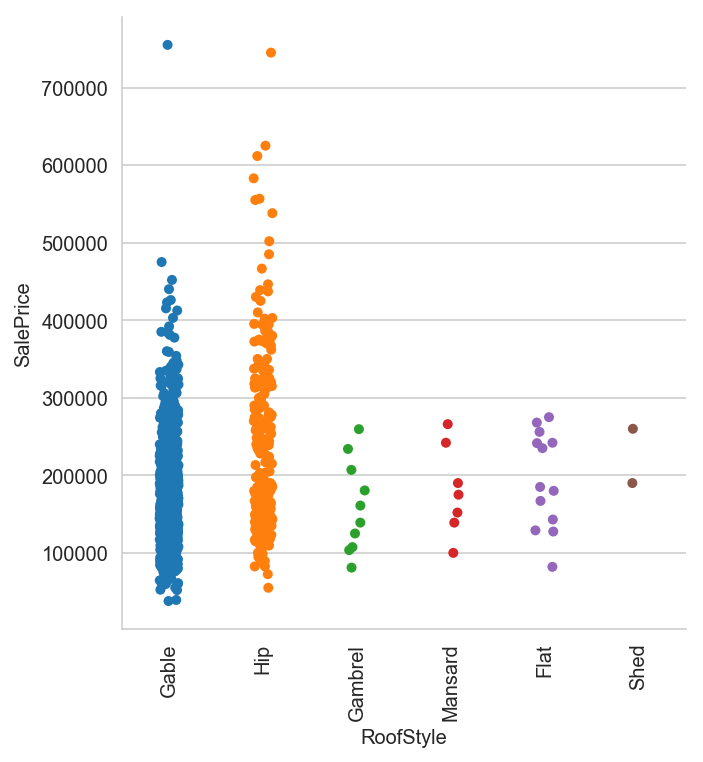

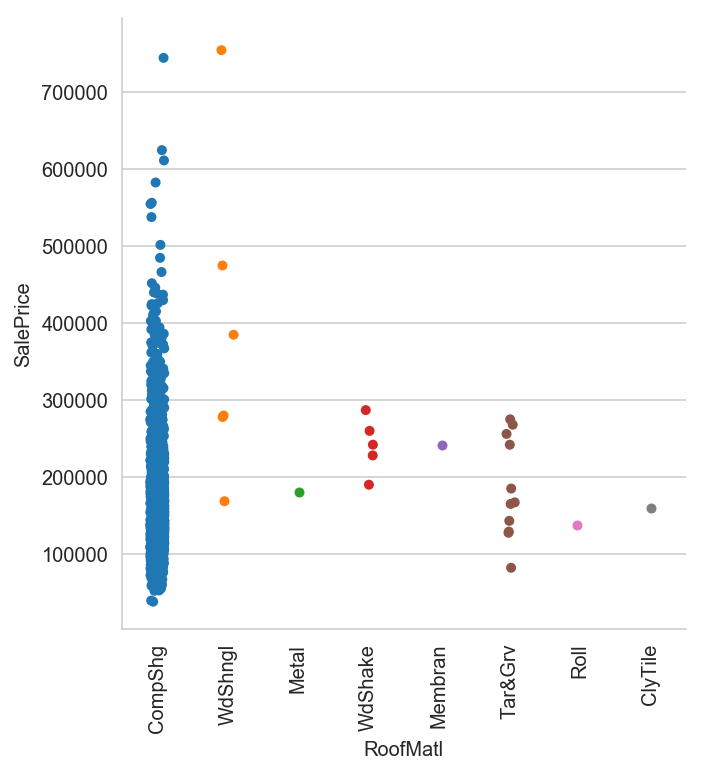

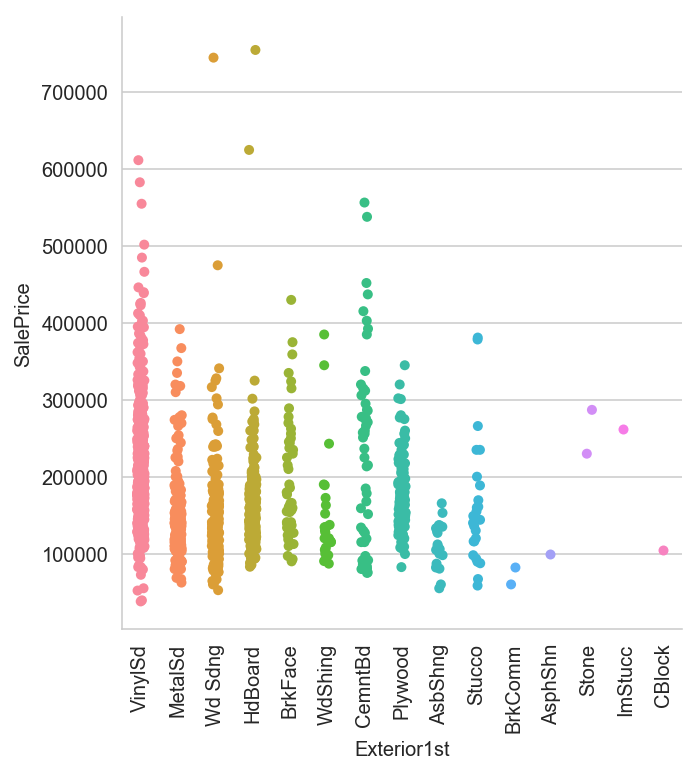

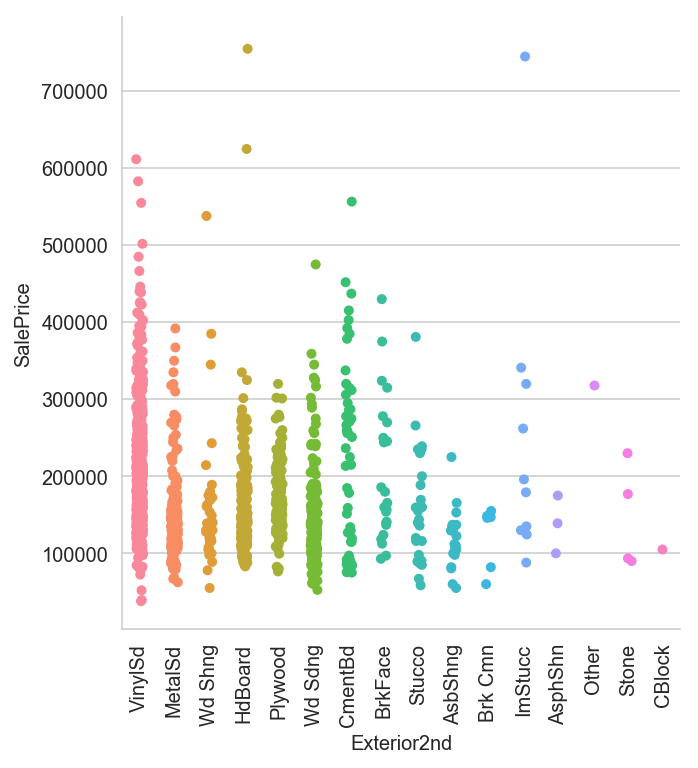

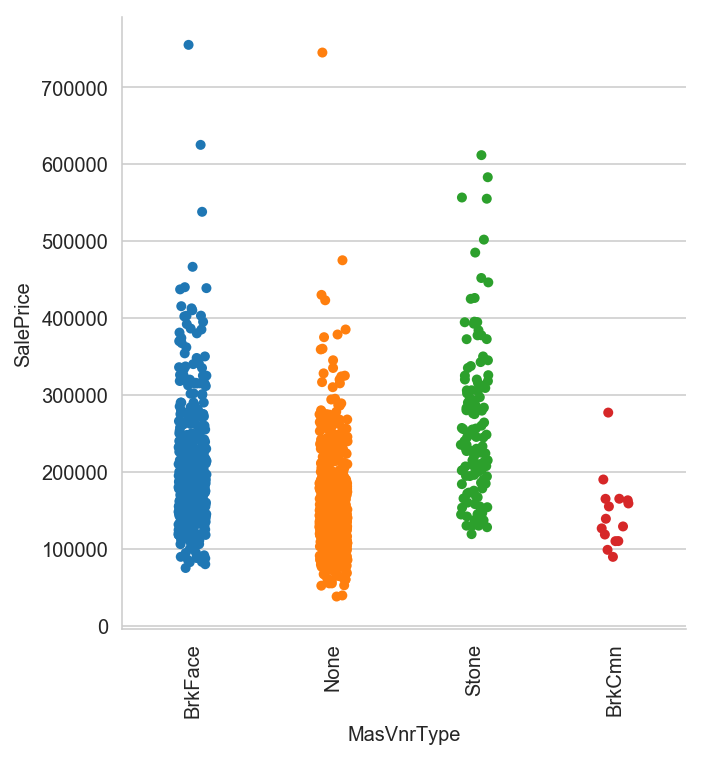

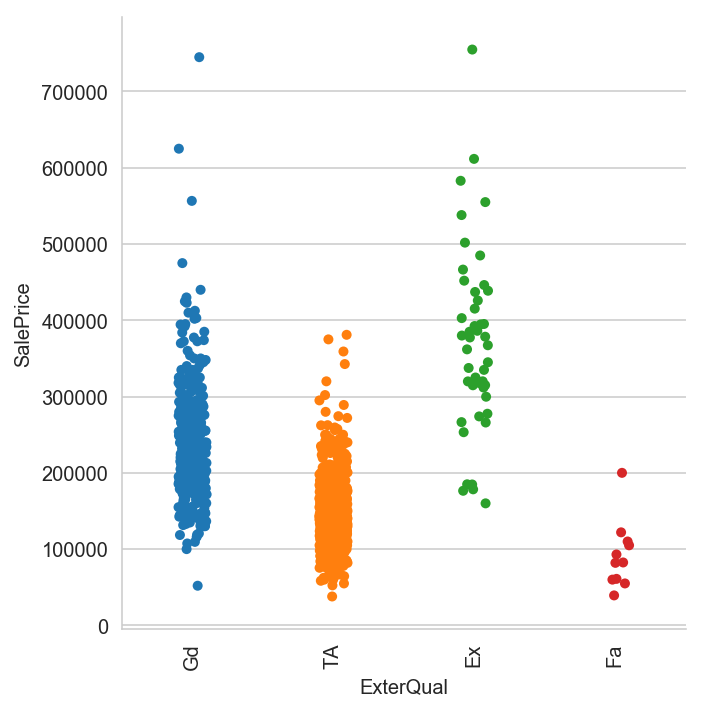

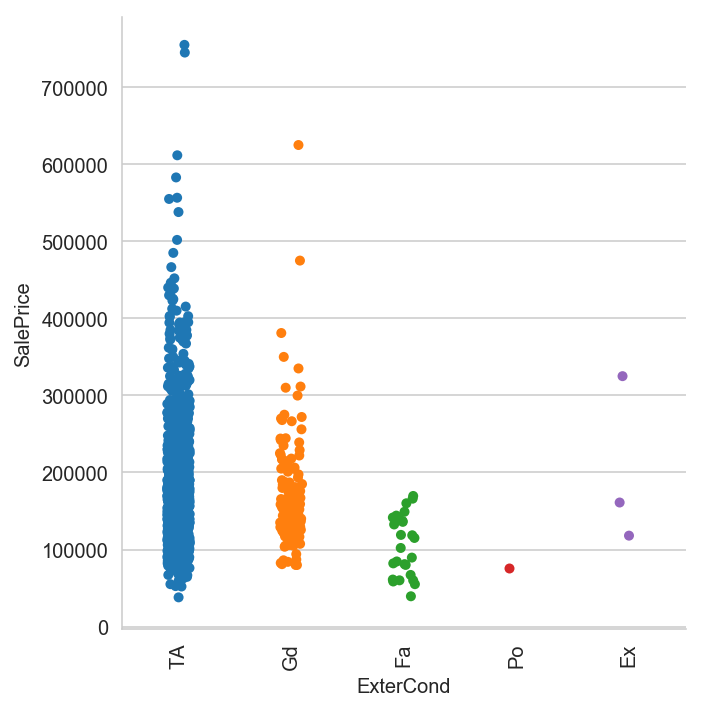

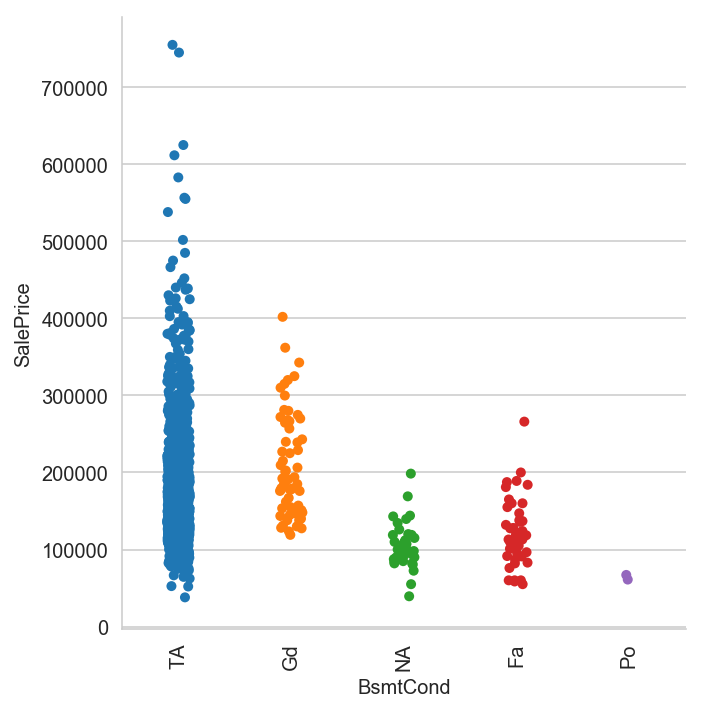

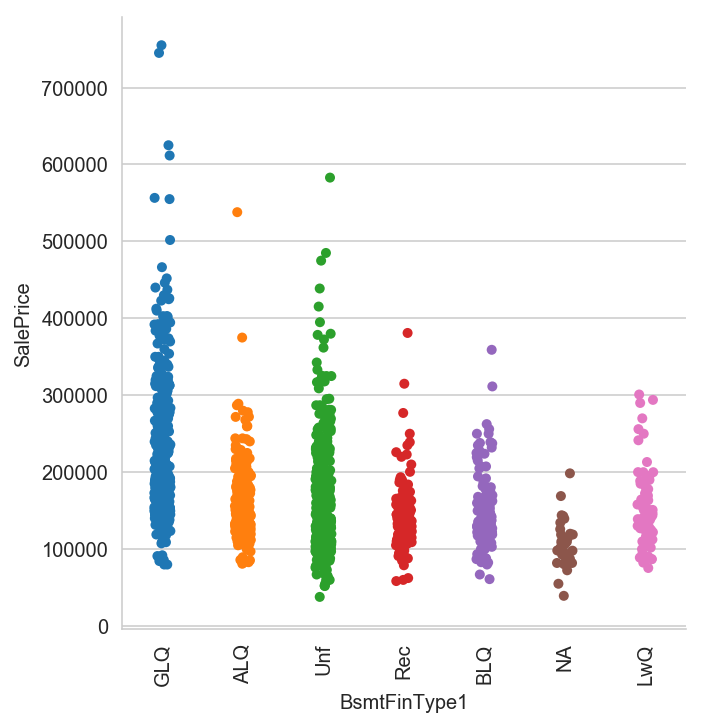

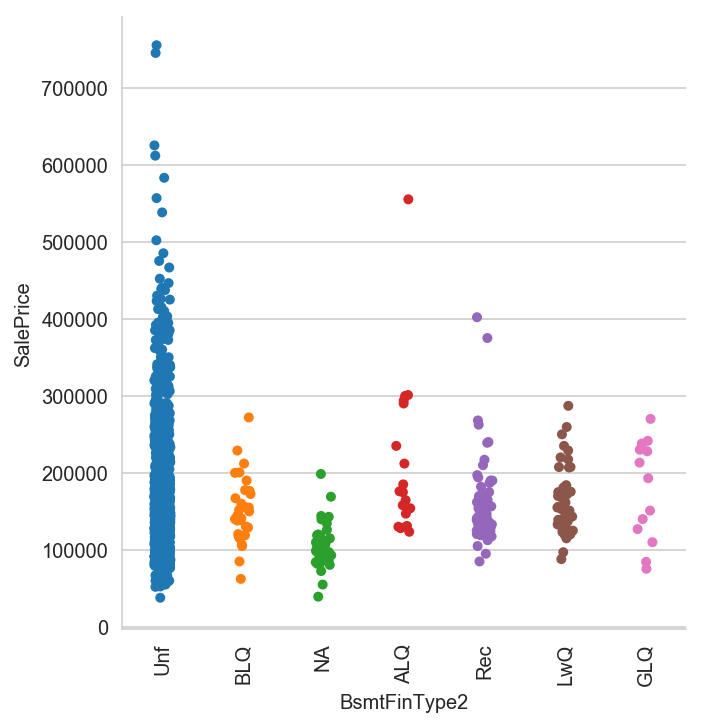

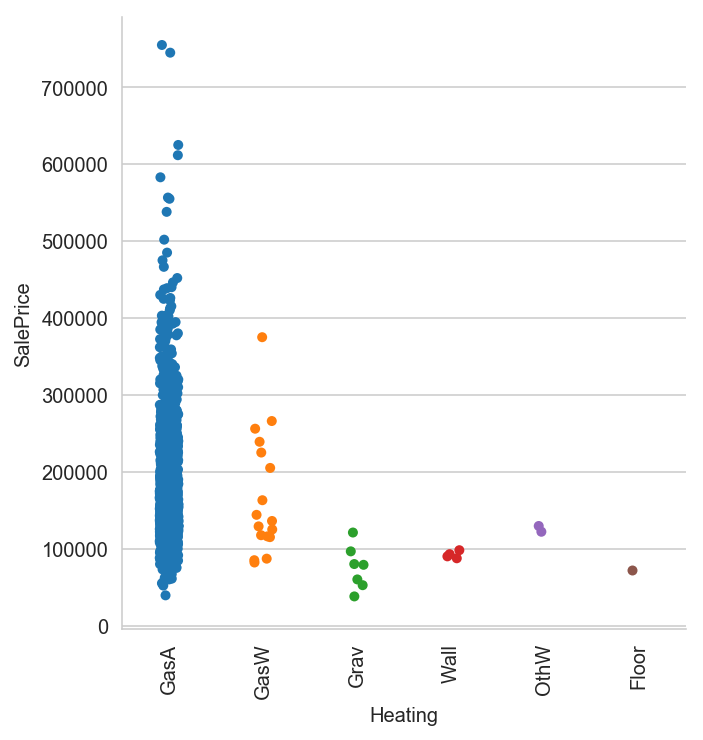

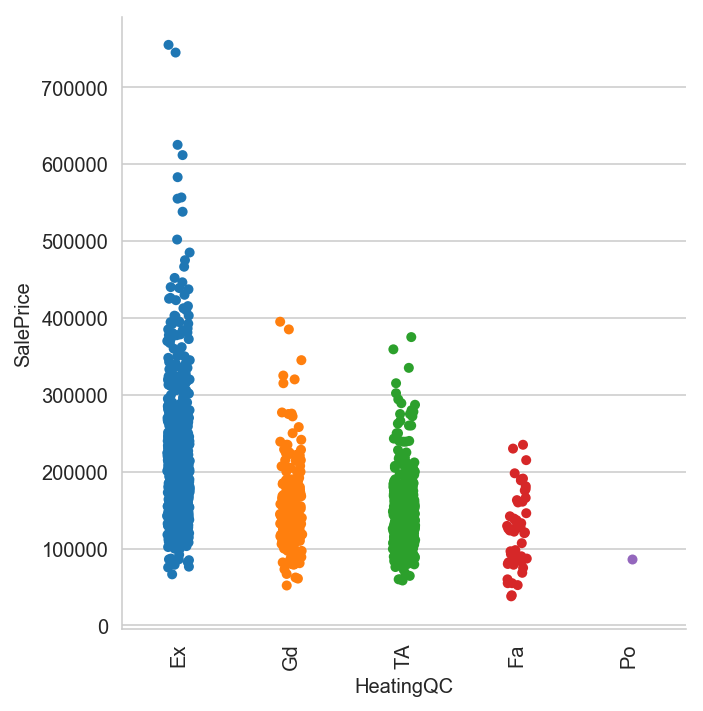

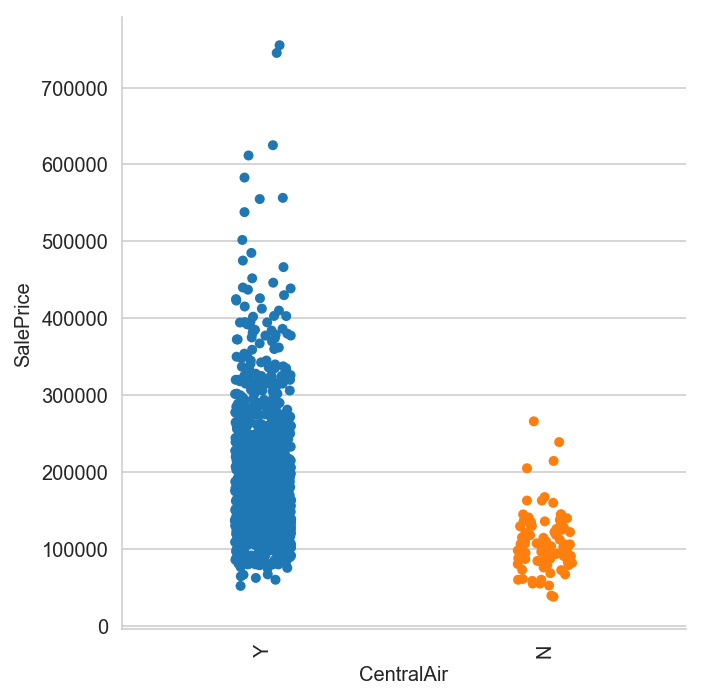

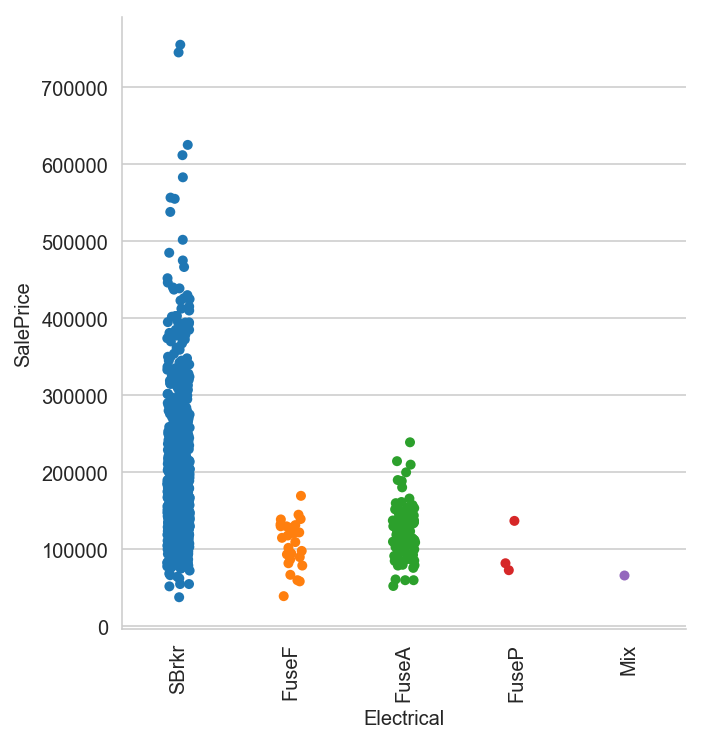

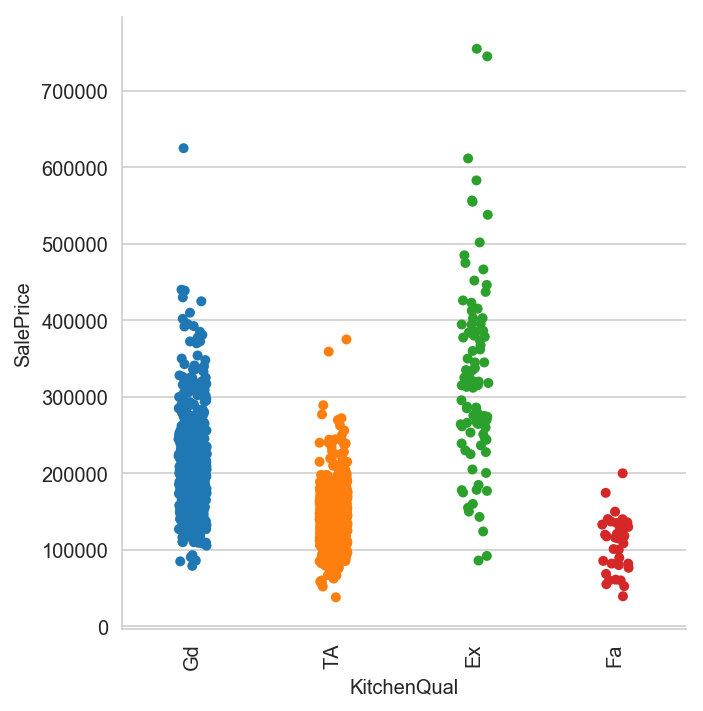

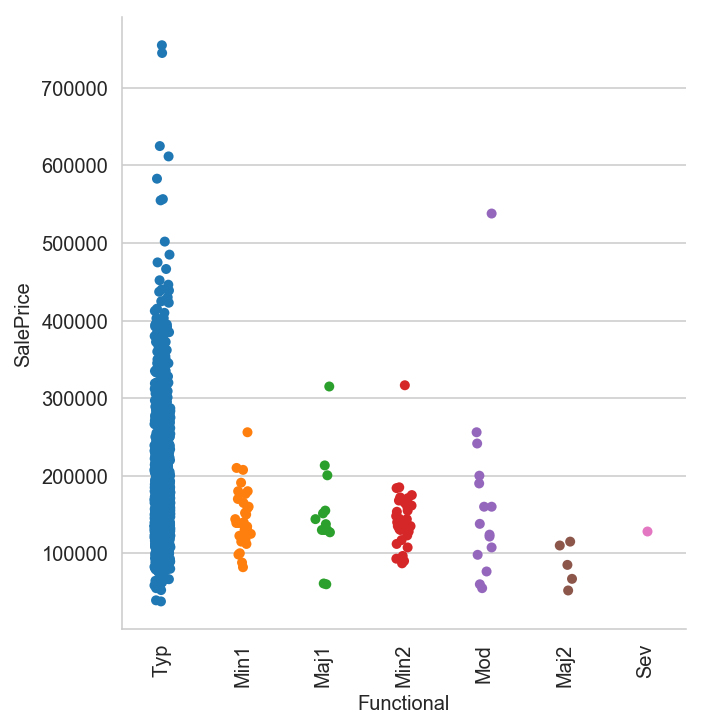

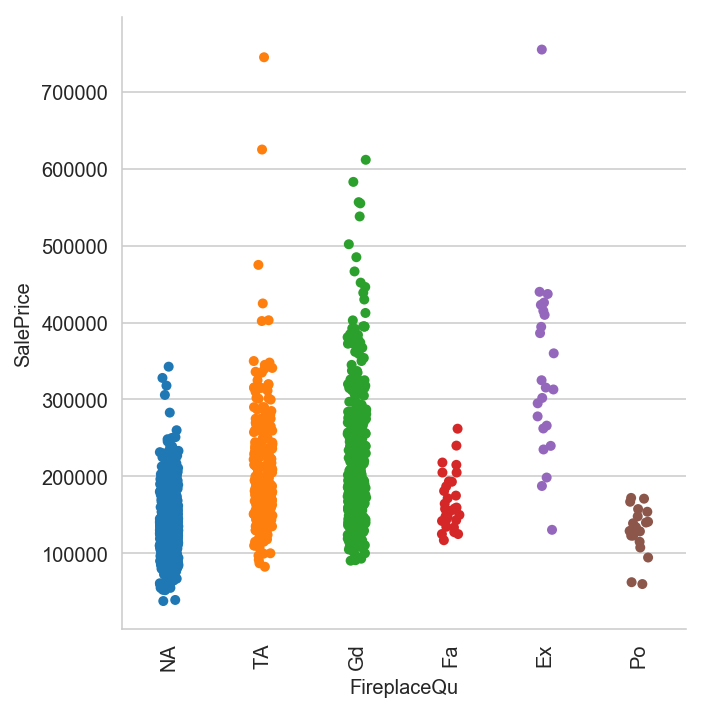

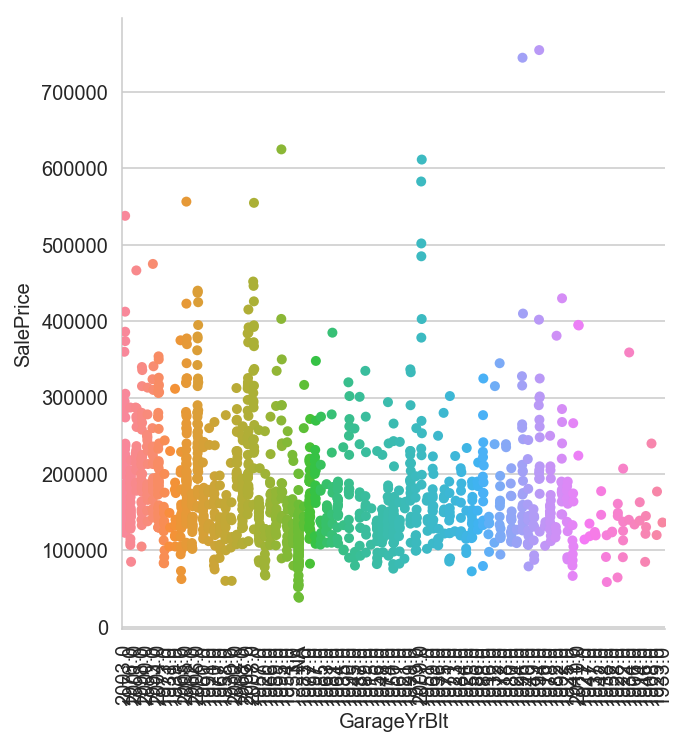

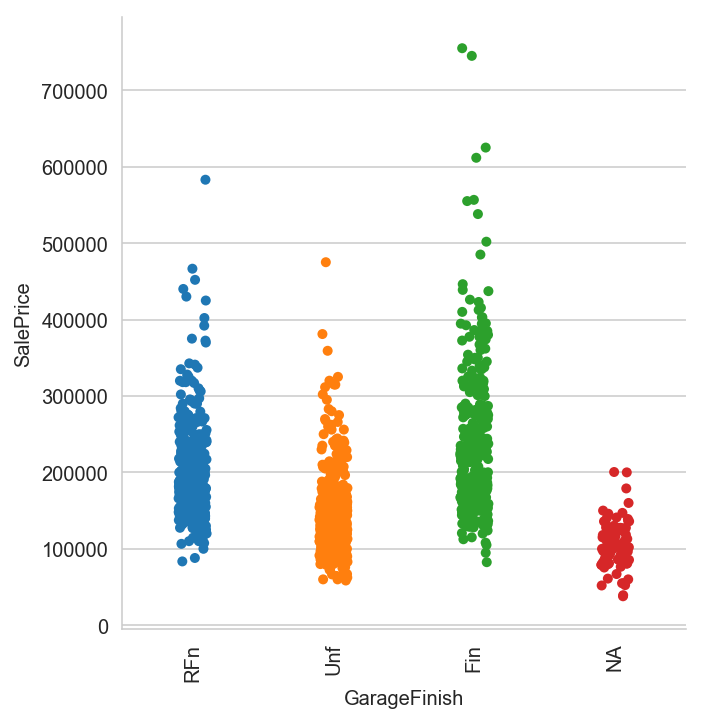

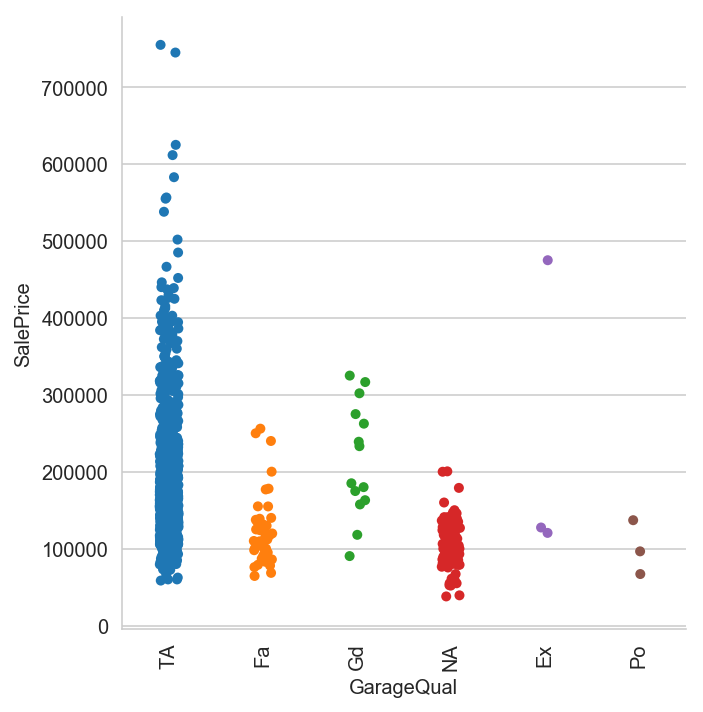

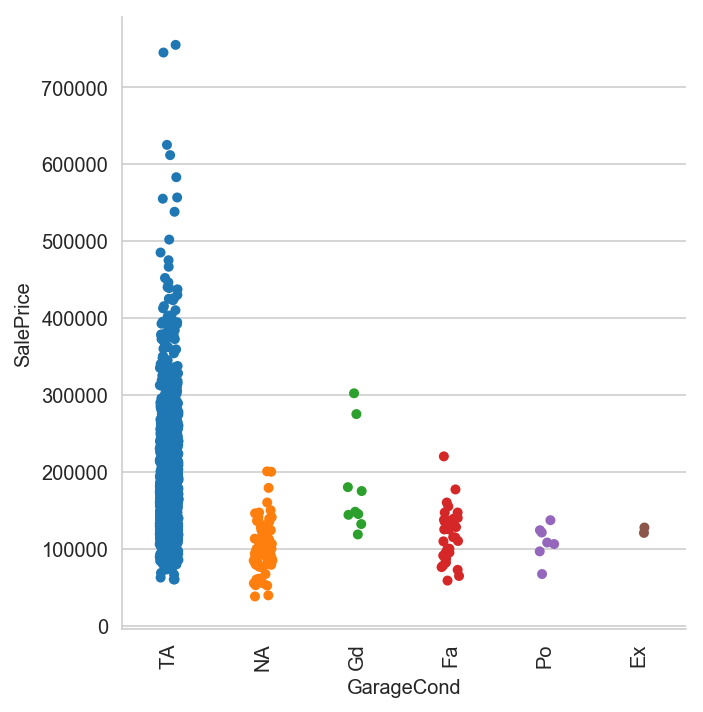

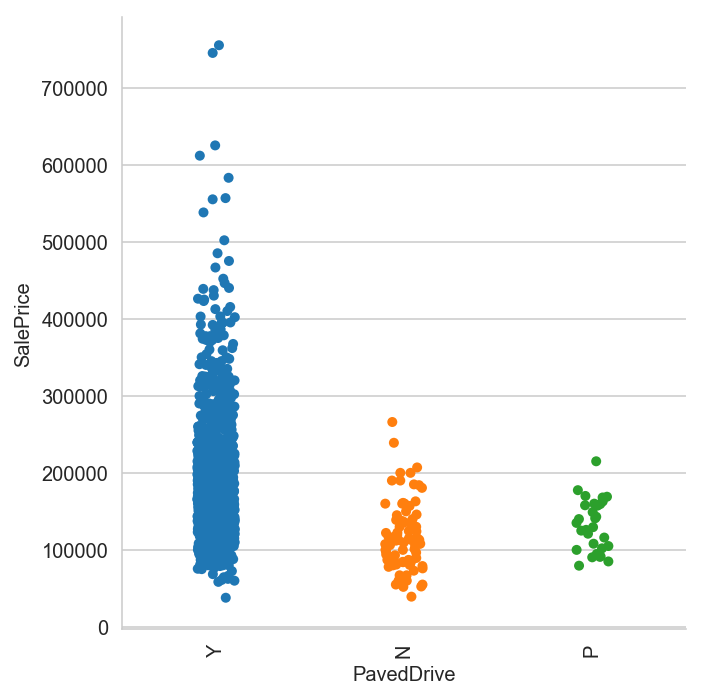

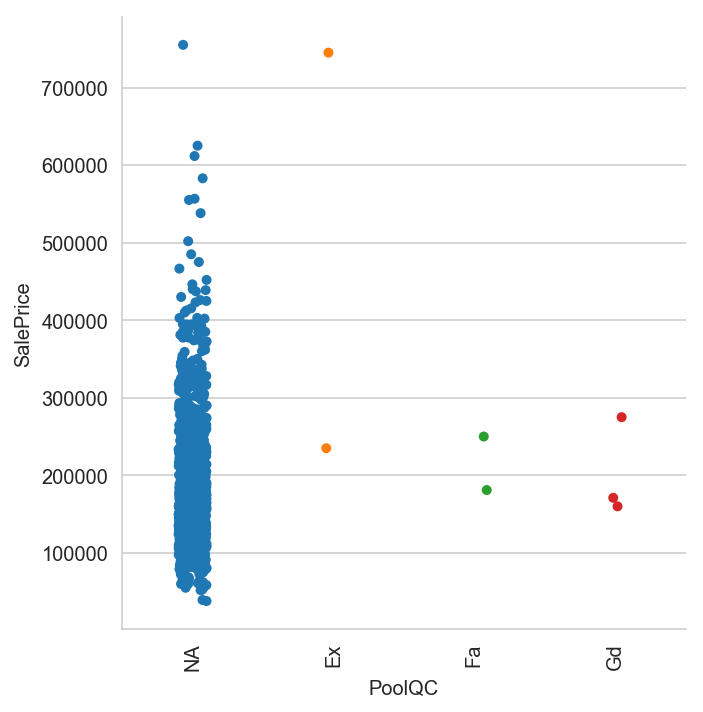

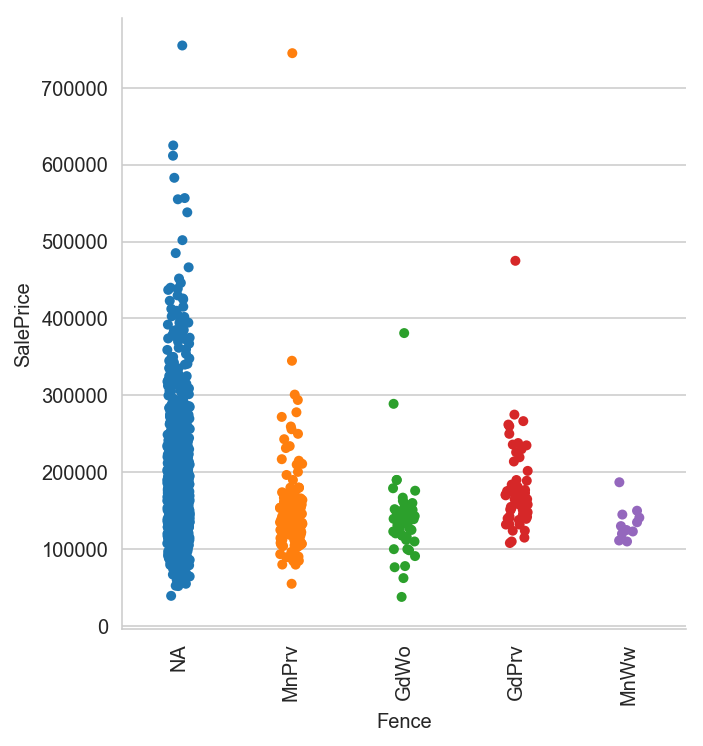

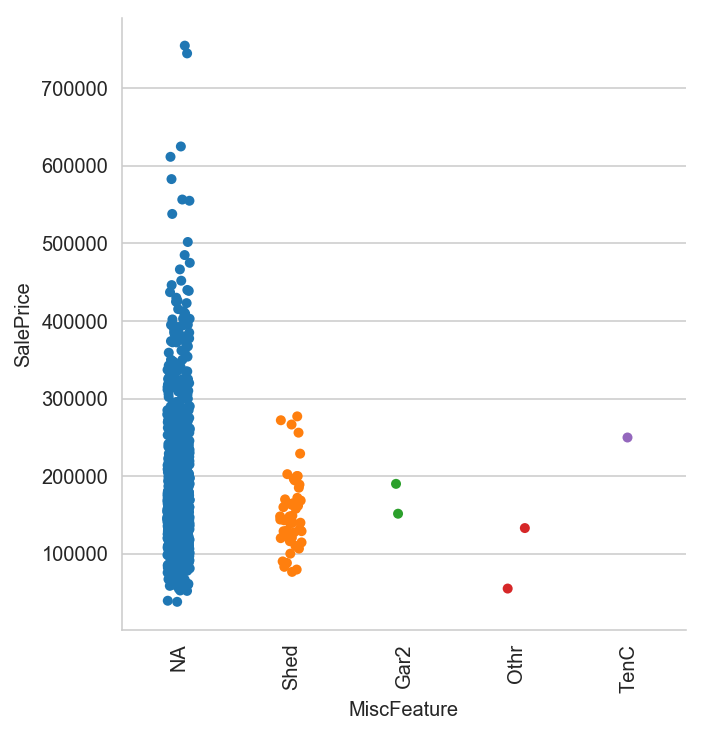

In [22]:
# To analyze all changeable categorical variables

# Loop through column list to plot boxplot for visual inspection and rough understanding of data_description.txt
for column in var_cat:
    g= sns.catplot(x=column, y="SalePrice", data=house_residential)
    g.set_xticklabels(rotation=90)

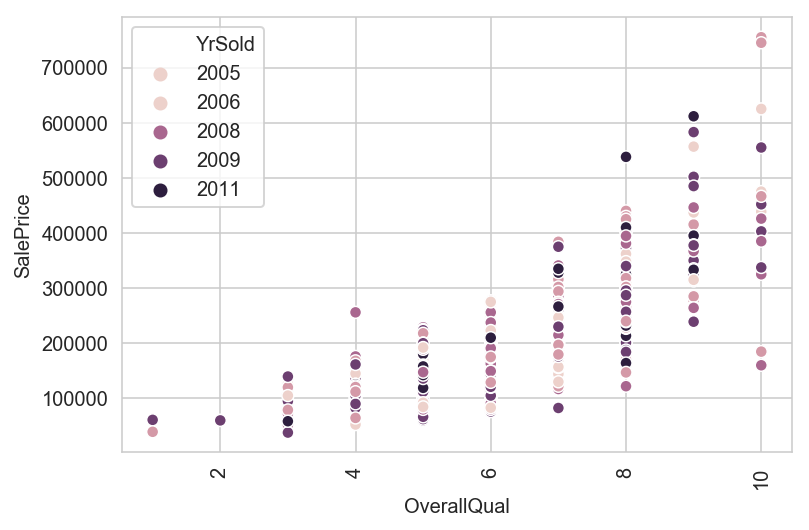

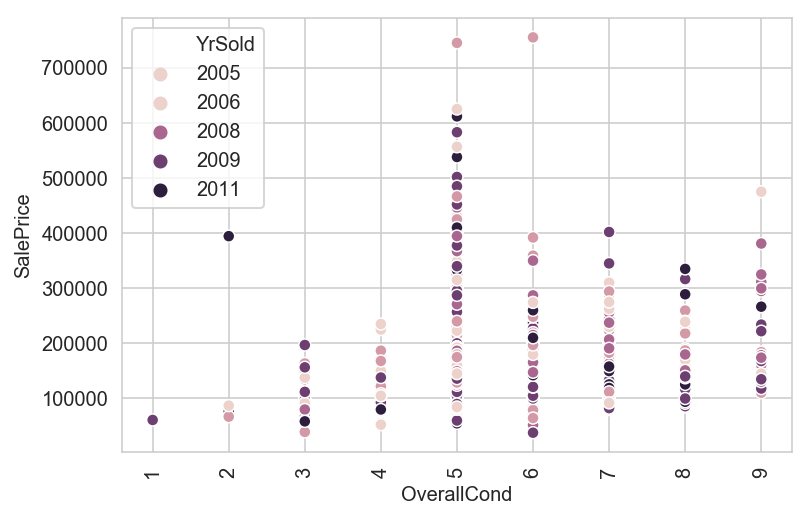

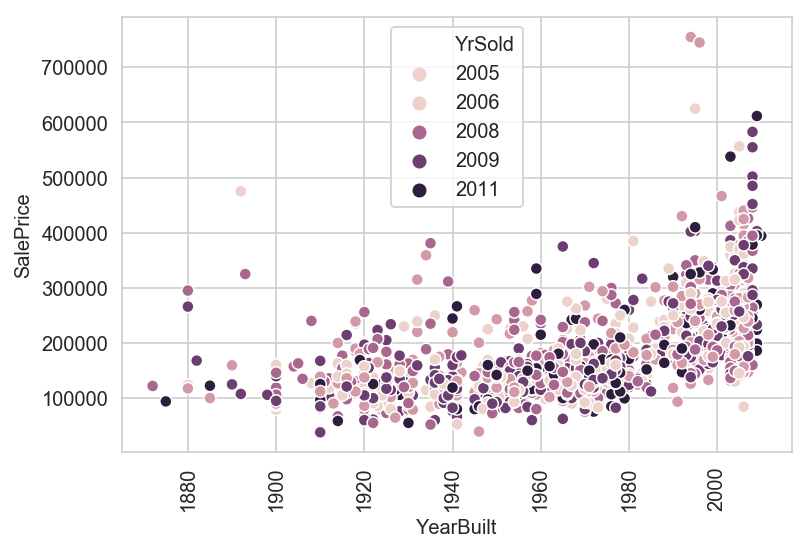

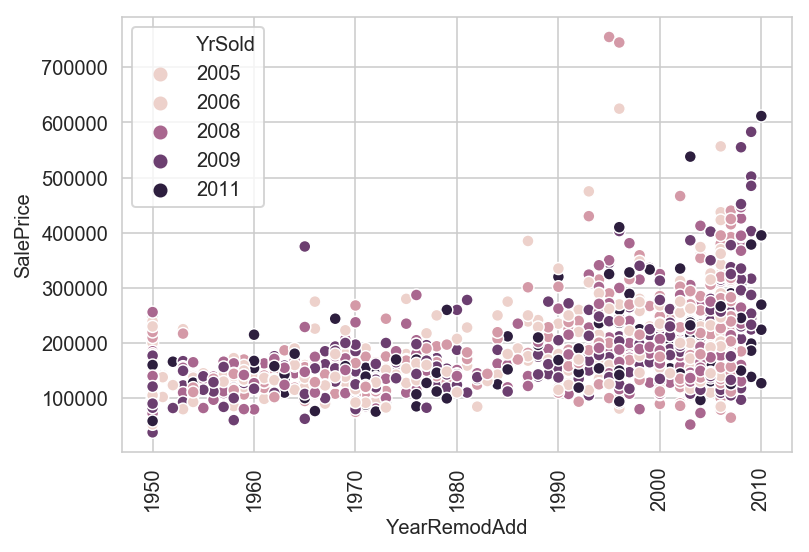

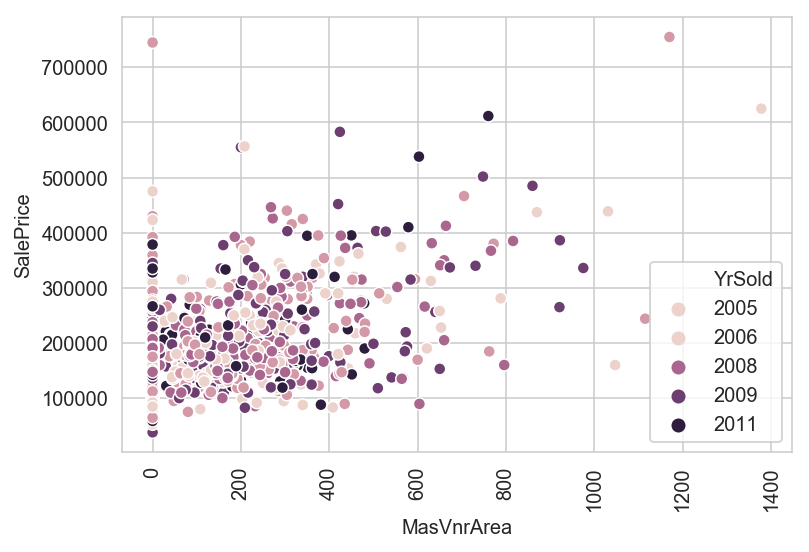

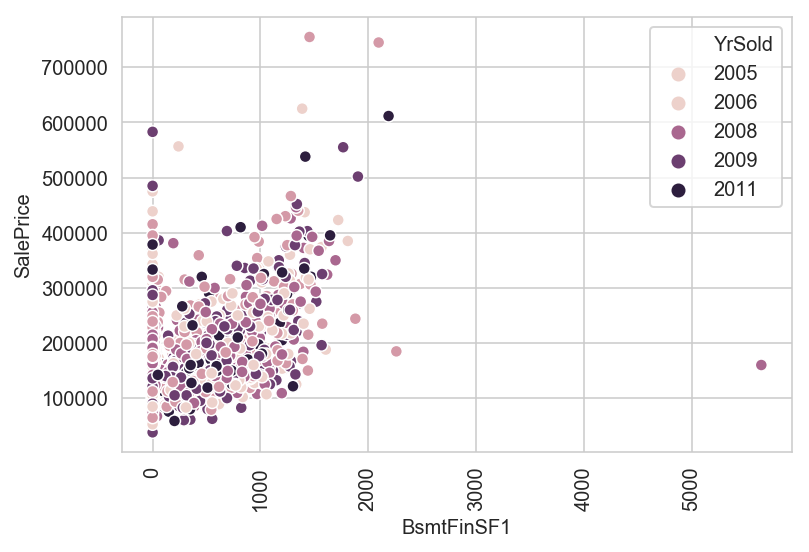

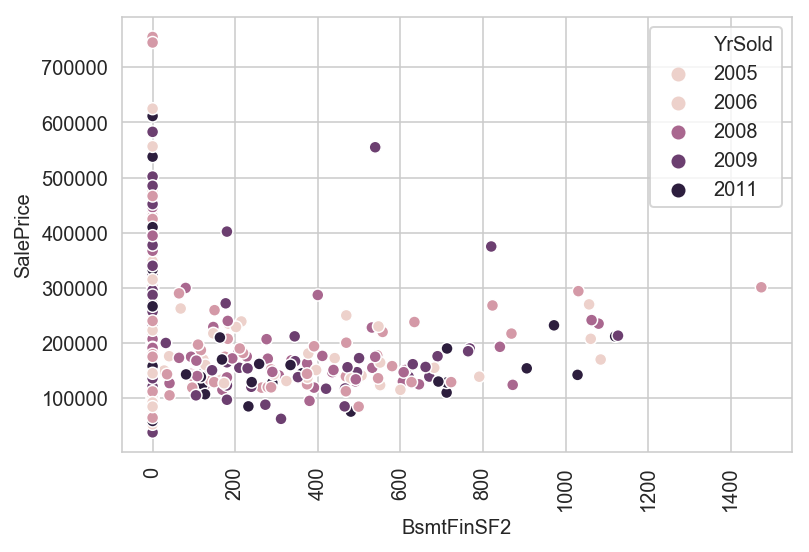

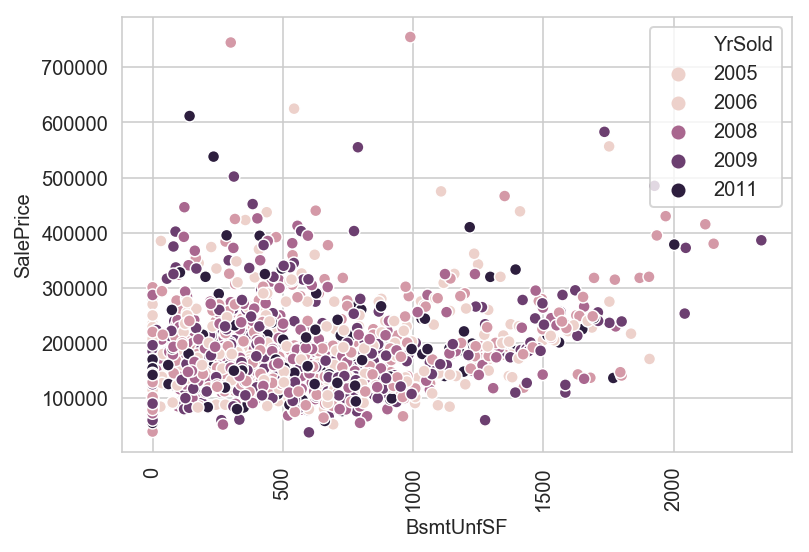

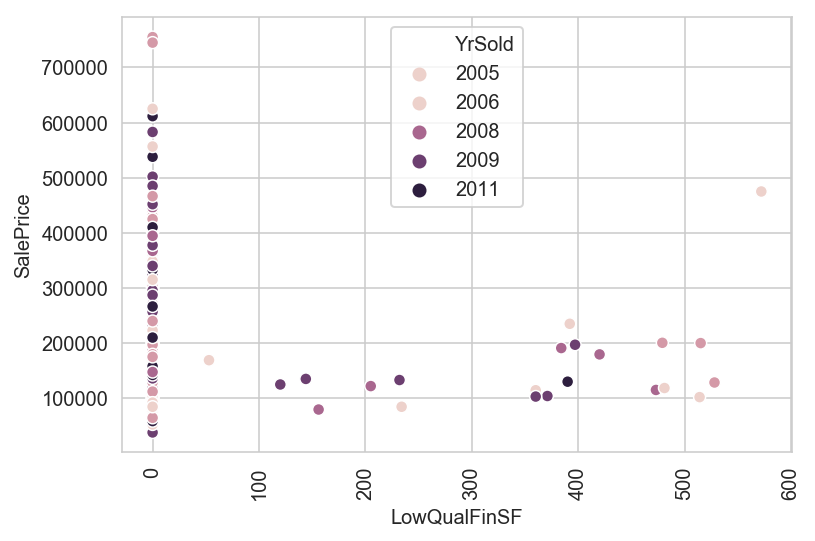

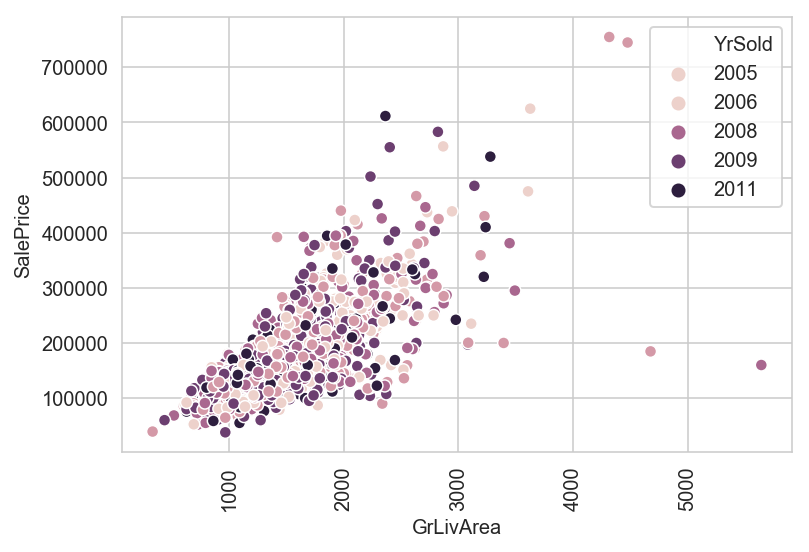

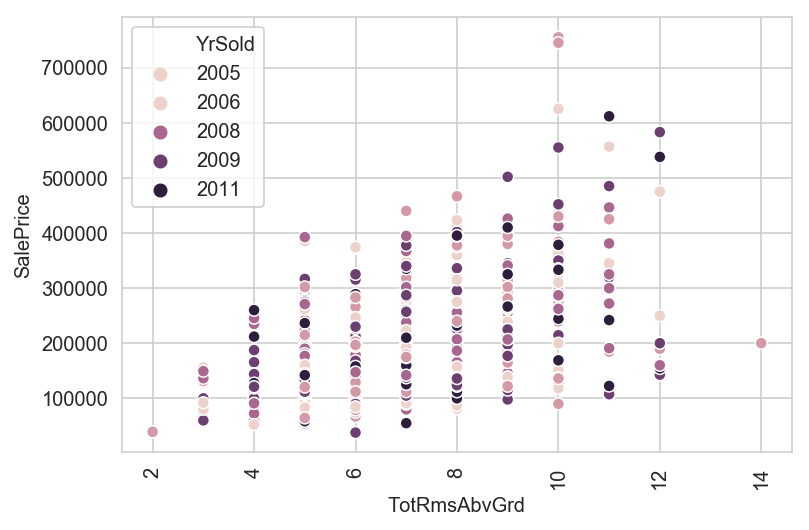

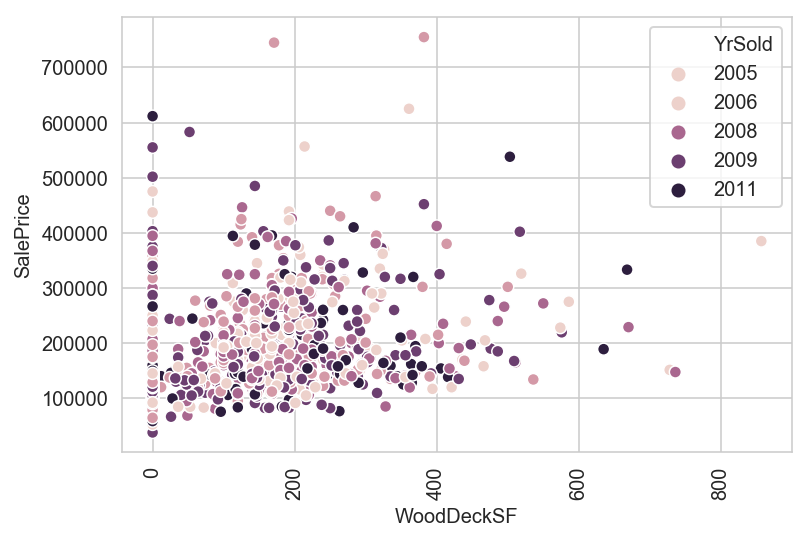

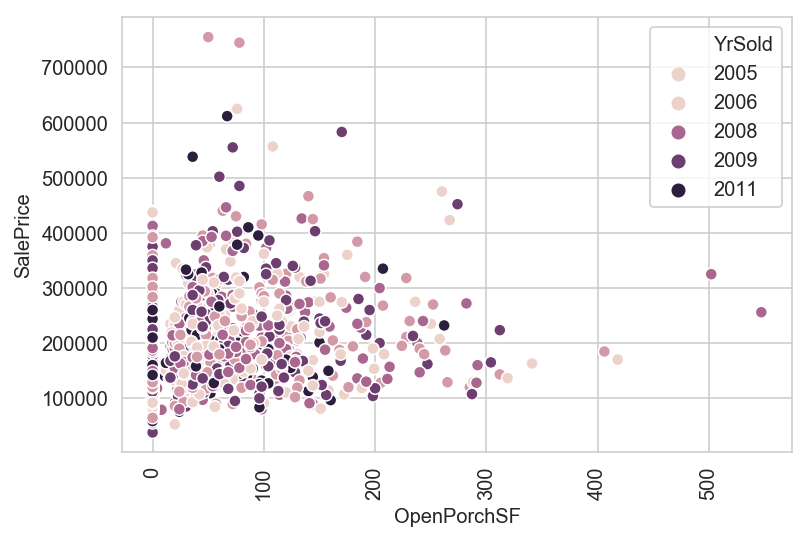

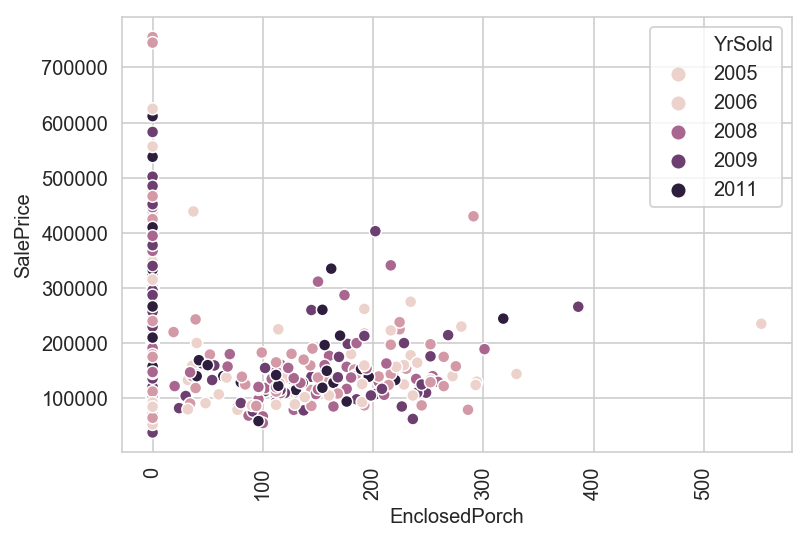

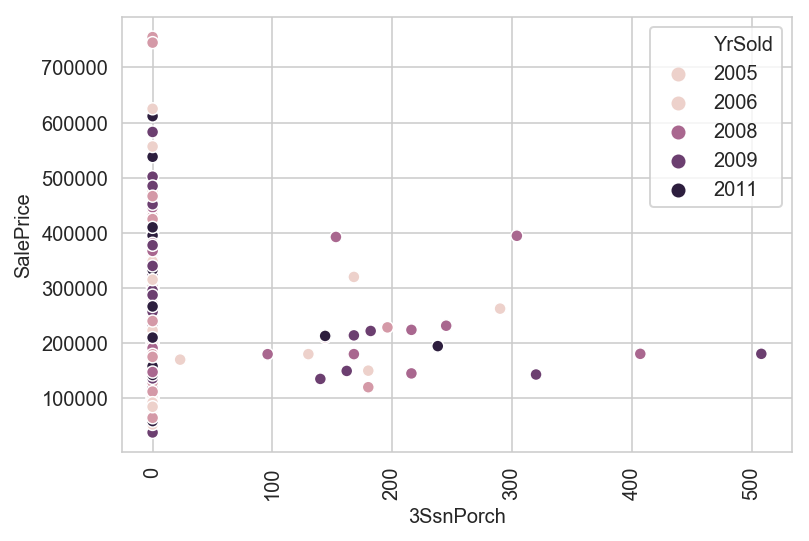

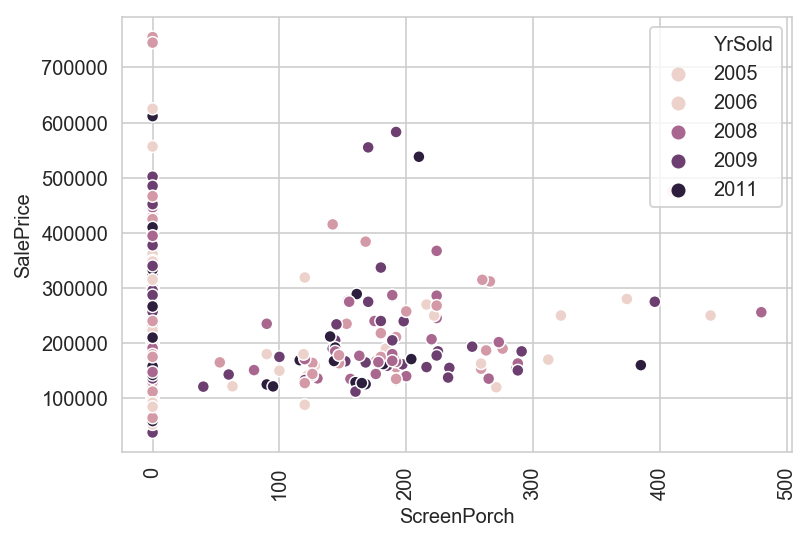

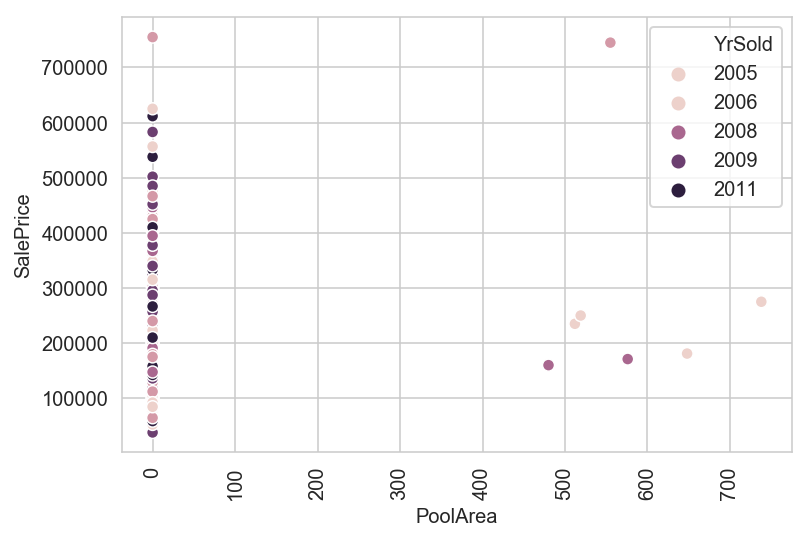

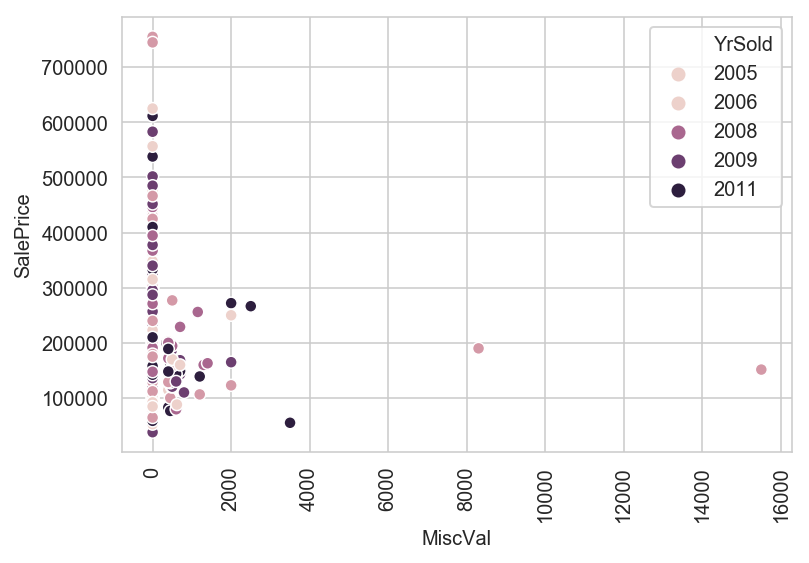

In [23]:
# To analyze all changeable continuous variables

# Loop through column list to plot boxplot for visual inspection and rough understanding of data
for column in var_cont:
    plt.figure()
    plt.xticks(rotation=90)
    sns.scatterplot(house_residential[column],house_residential['SalePrice'],hue=house_residential['YrSold'])

### A) To train and test model with both fixed and changeable predictor variable

In [128]:
# Convert categorical variables into dummy variables for regression
# Split data into two datasets: pre-2010 and 2010

all_predict_var = house_residential[all_pred_var].copy()
target_var = house_residential['SalePrice']

full_col_all_predict_var = pd.get_dummies(all_predict_var).columns
all_predict_var = pd.get_dummies(all_predict_var,drop_first=True)

all_predict_var_train = all_predict_var[all_predict_var['YrSold'] < 2010].drop('YrSold',axis=1)
all_predict_var_test = all_predict_var[all_predict_var['YrSold'] == 2010].drop('YrSold',axis=1)

In [131]:
# Saving the reference baseline basis first dummy column dropped for all categorical variables
all_dummy_col = [col for col in full_col_all_predict_var if col not in all_predict_var]
print(all_dummy_col)

['MSSubClass_20', 'MSZoning_RH', 'Street_Grvl', 'Alley_Grvl', 'LotShape_IR1', 'LandContour_Bnk', 'Utilities_AllPub', 'LotConfig_Corner', 'LandSlope_Gtl', 'Neighborhood_Blmngtn', 'BldgType_1Fam', 'HouseStyle_1.5Fin', 'RoofStyle_Flat', 'RoofMatl_ClyTile', 'MasVnrType_BrkCmn', 'ExterQual_Ex', 'ExterCond_Ex', 'Foundation_BrkTil', 'BsmtQual_Ex', 'BsmtCond_Fa', 'BsmtExposure_Av', 'BsmtFinType1_ALQ', 'BsmtFinType2_ALQ', 'Heating_Floor', 'HeatingQC_Ex', 'CentralAir_N', 'Electrical_FuseA', 'KitchenQual_Ex', 'Functional_Maj1', 'FireplaceQu_Ex', 'GarageType_2Types', 'GarageYrBlt_1906.0', 'GarageFinish_Fin', 'GarageQual_Ex', 'GarageCond_Ex', 'PavedDrive_N', 'PoolQC_Ex', 'Fence_GdPrv', 'MiscFeature_Gar2', 'SaleType_COD', 'SaleCondition_Abnorml']


In [132]:
# Setting up hyperparameters for model
# Re-fitting model once more with all predictor variables (fixed & changeable). This is because with the inclusion of
# changeable predictor variables, it may change the coefficient of fixed predictor variables to obtain a better model.

from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import cross_val_score

all_optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1,normalize=True)
all_optimal_lasso.fit(all_predict_var_train, target_var_train)
print("The optimal alpha for the lasso model is: {}.".format(all_optimal_lasso.alpha_))

all_lasso = Lasso(alpha=all_optimal_lasso.alpha_,normalize=True)
all_lasso_scores = cross_val_score(all_lasso,all_predict_var_train,target_var_train,cv=10)

print(all_lasso_scores,np.mean(all_lasso_scores))

all_lasso.fit(all_predict_var_train,target_var_train)
all_lasso_coefs = pd.DataFrame({'pred_var':all_predict_var_train.columns,
                            'coef':all_lasso.coef_,
                            'abs_coef':np.abs(all_lasso.coef_)})

all_lasso_coefs.sort_values('abs_coef',inplace=True,ascending=False)

print('Percent variables zeroed out: {}%'.format(np.sum((all_lasso.coef_ == 0))/float(len(all_lasso.coef_))*100))
all_lasso_coefs.head()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

The optimal alpha for the lasso model is: 32.99854175887355.
[0.9101859  0.89010809 0.87541379 0.74204827 0.86612407 0.86445303
 0.89539162 0.81619395 0.52236834 0.82720891] 0.8209495976783394
Percent variables zeroed out: 75.14450867052022%


pred_var           coef       abs_coef
323             PoolQC_Gd -141095.147973  141095.147973
137      RoofMatl_WdShngl   76366.514962   76366.514962
105  Neighborhood_NoRidge   46239.211728   46239.211728
112  Neighborhood_StoneBr   45640.662518   45640.662518
304    GarageYrBlt_2009.0   42918.651910   42918.651910

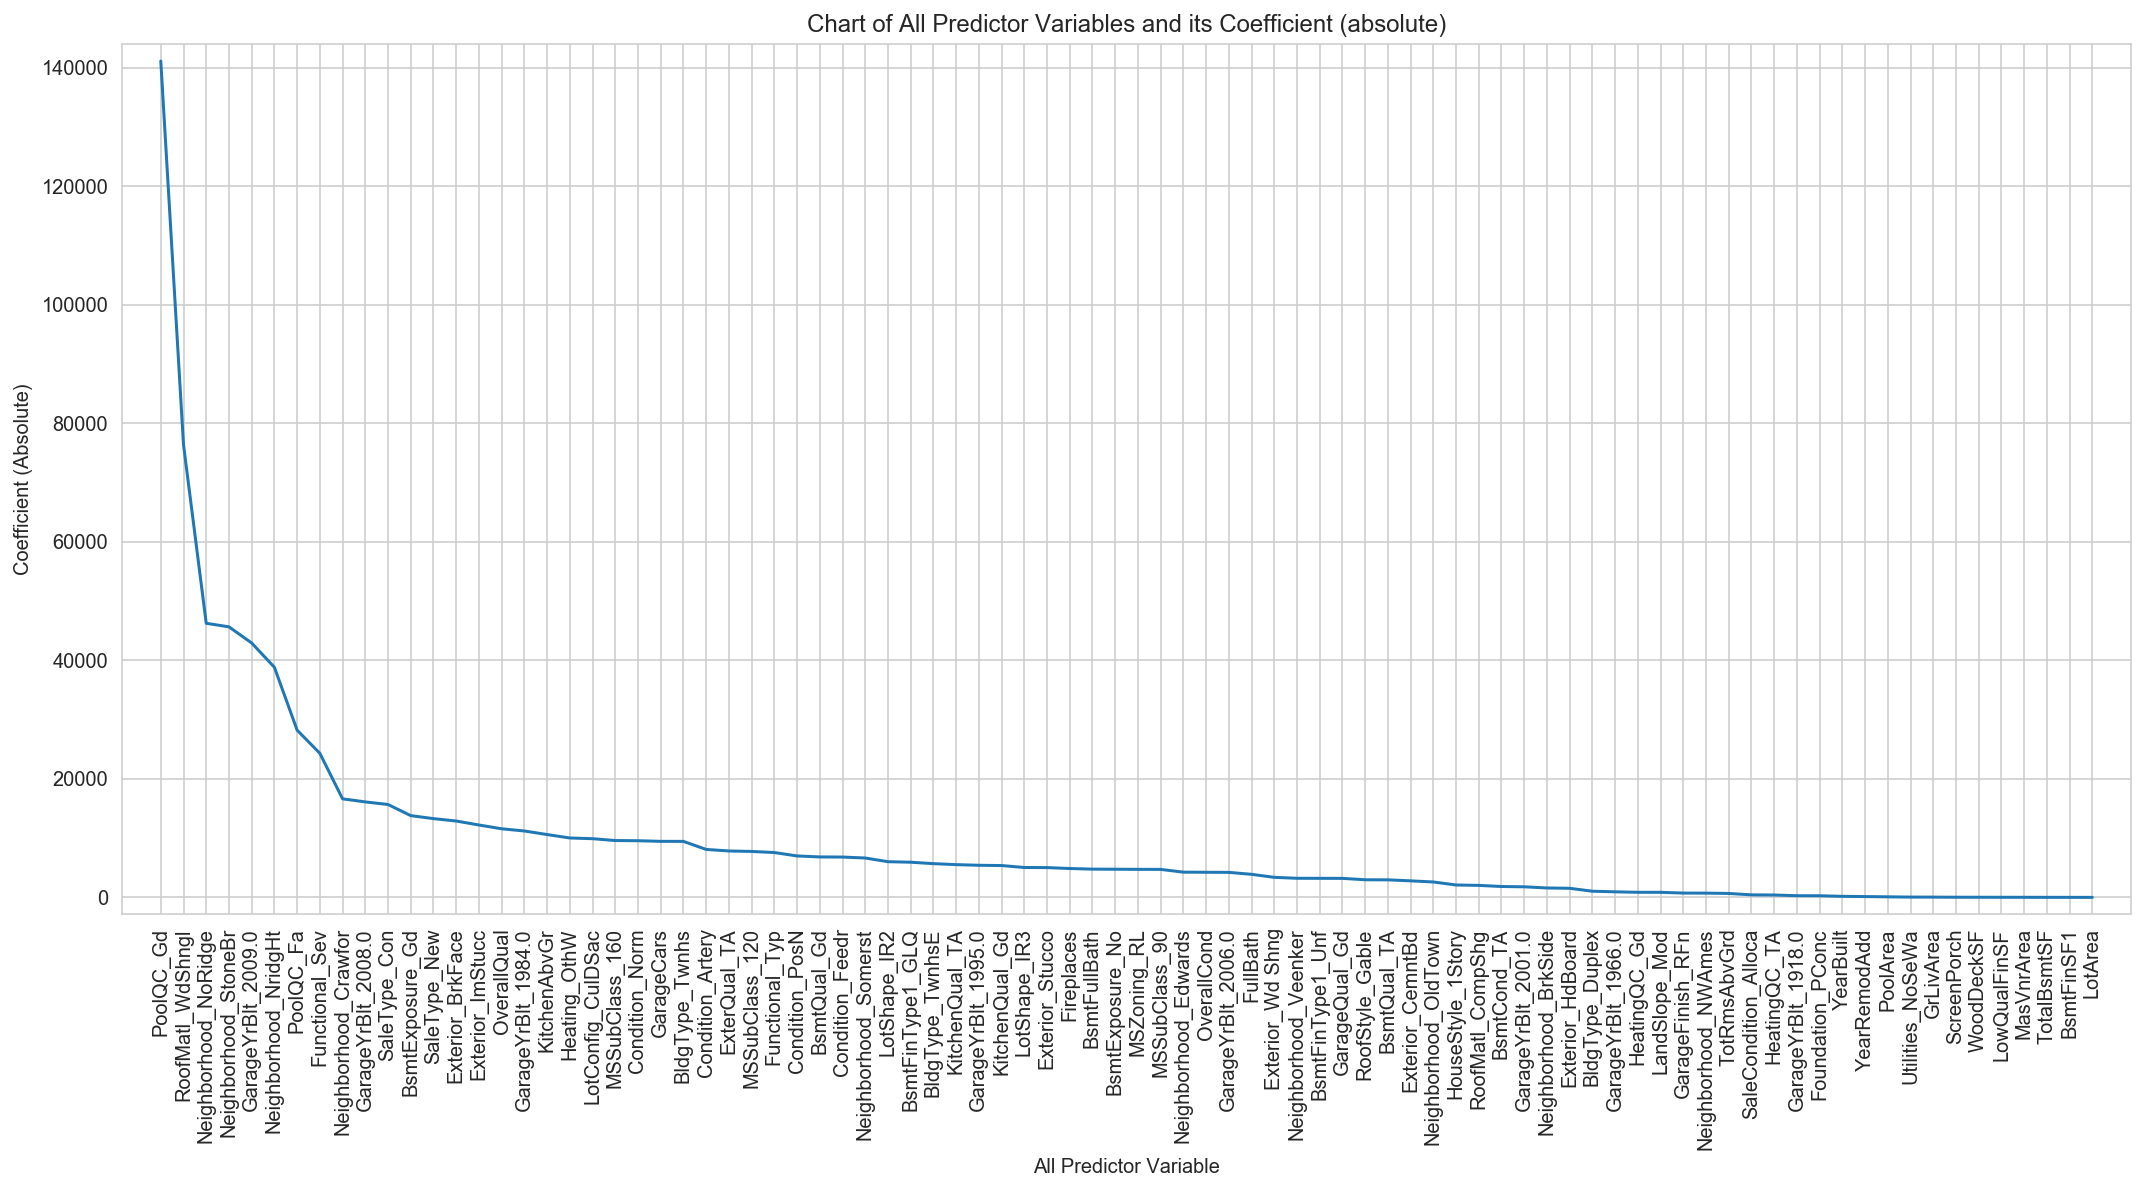

In [133]:
# Plot the coefficients that is not 0
# To omit coefficients that are 0 due to the sheer number of predictor variables

all_non_zero = all_lasso_coefs[all_lasso_coefs['abs_coef']!=0]

plt.figure(figsize=(18,8))
plt.plot(range(len(all_non_zero)), all_non_zero['abs_coef'])
plt.xticks(range(len(all_non_zero)), all_non_zero['pred_var'], rotation=90)
plt.title('Chart of All Predictor Variables and its Coefficient (absolute)')
plt.xlabel('All Predictor Variable')
plt.ylabel('Coefficient (Absolute)')
plt.margins(0.02)
plt.show()

#### To evaluate model performance against initial model with fixed predictor varbales only

In [135]:
all_test_score = all_lasso.score(all_predict_var_test,target_var_test)

print("The R-squared score for the 2010 houses is: {}.".format(all_test_score))
print("This is a good score as it explains approximately {}% of the variance in the target variable from its mean.\n".format(int(all_test_score*100)))

The R-squared score for the 2010 houses is: 0.8826977014400115.
This is a good score as it explains approximately 88% of the variance in the target variable from its mean.



In [137]:
all_non_zero = all_lasso_coefs[all_lasso_coefs['abs_coef']!=0].copy()

all_non_zero['prefix'] = [row.split("_")[0] for row in all_non_zero['pred_var']]
all_coef_impt = all_non_zero.groupby(['prefix'], sort=True)['abs_coef'].max()

model1_fixed = list(set(non_zero['prefix']))
model2_all = list(set(all_non_zero['prefix']))

model2_fixed_pred = [var for var in model2_all if var in model1_fixed]
model2_var_pred = [var for var in model2_all if var in var_pred_var]

print("There are {} relevant predictor variables: {} fixed, {} changeable.\n". \
      format(len(model2_all),len(model2_fixed_pred),len(model2_var_pred)))

print("The top 10 most relevant predictor variables are: ")
all_coef_impt.sort_values(ascending=False).head(10)

There are 48 relevant predictor variables: 20 fixed, 26 changeable.

The top 10 most relevant predictor variables are: 


prefix
PoolQC          141095.147973
RoofMatl         76366.514962
Neighborhood     46239.211728
GarageYrBlt      42918.651910
Functional       24301.854244
SaleType         15669.277823
BsmtExposure     13793.264079
Exterior         12883.740646
OverallQual      11573.514704
KitchenAbvGr     10600.216883
Name: abs_coef, dtype: float64

In [138]:
fixed_pred_removed = [var for var in model1_fixed if var not in model2_all]
print("{} fixed predictor variables used in the baseline model was not used in the second model with changeable variables" \
      .format(len(fixed_pred_removed)))

9 fixed predictor variables used in the baseline model was not used in the second model with changeable variables


#### 1) Evaluate the effect in dollars of the renovate-able features
For categorical features, the coefficient showcases the sale price impact from the presence of said-categorical feature.<br>
- E.g: PoolQC_Gd has a negative co-efficient of approx -150,000, which is means if a property is assessed to have a pool quality that is good, the property's sale price will be lower by approx -150,000 from the reference variable which in this case is pool quality excellent (PoolQC_Ex).

For continuous features, the coefficient showcases the sale price impact of a **normalized** continuous feature. <br>

#### 2) How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. <br>

There are two possible conditions, which are not mutually exclusive, under which the company can buy a property: <br>
- Property's asking price is below the predicted market price given its current condition (undervalued, can be flipped)
- Property is able to sell at a profit after renovation, and factoring the purchase price and renovation costs (fixer-upper)

To identify undervalued properties, the company should:
1. Undertake an extensive assessment of the fixed and changeable features (predictor variables with non-zero coefficient, as identified by the model) of the property for-sale
2. Predict the sale price of the property by passing the features into the model
3. To be conservative, the model's predicted sale price will be adjusted downwards by 3.5% (11% variance converted to standard deviation) resulting in a under priced prediction.
4. If the asking price is: <br>
> - Higher than the adjusted predicted price, the property is **overvalued**. No further action required.
> - Equal to the adjusted predicted price, the property is **fair-valued** for its current condition. No opportunity for flipping, but there is potential to be a fixer-upper (to evaluate based on guideline below)
> - Lower than adjusted predicted price, the property is **undervalued**. Company should consider hiring a market surveyor to verify the price prediction, and potentially make a move to flip the property is the potential profits outweigh the additional costs to be incurred when flipping.

For fair/undervalued properties, the next step is to identify their potential as a fixer-upper:
5. Determine a desired return on investment, absolute or in percentage (e.g. 10k USD or 10% from each fixer-upper)
6. Evaluate the potential renovation profit, by calculating the sale price increase from improving the feature's grade minus renovation cost, for each changeable feature that is not of the highest grade.*
7. For the property, if potential renovation profit meets or exceeds the desired return on investment, it would qualify as a potential fixer-upper.

**Note:* This approach to evaluating potential renovation profit assumes that the model's predicted sale price increase from improving the feature's grade is reliable. However, this assumption may not be valid for all changeable features. Refer to Qn4, sub-section 'Specific' for a detailed explanation.

#### 3) Investigate how much of the variance in price remaining is explained by these features.

In [139]:
improvement = all_test_score - test_score
print("The inclusion of changeable predictor variables improved the inital fixed predictor variable-only model by explaining an additional {}% of the variance in the target variable from its mean.\n".format(int(improvement*100)))
print("{}% of the variance in the historical sale price vs. predicted sale price cannot be explained by the possible predictor variables provided in the dataset.".format(int((1-all_test_score)*100)))

The inclusion of changeable predictor variables improved the inital fixed predictor variable-only model by explaining an additional 1% of the variance in the target variable from its mean.

11% of the variance in the historical sale price vs. predicted sale price cannot be explained by the possible predictor variables provided in the dataset.


#### 4) Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

This question will be answered in two-levels: specific to the model, and in general, to similar machine-learning models. 

**Specific**

The model appears to be weak at interpreting the price impact of certain changeable variables (renovate-able features), based on the significantly large negative coefficient of certain categorical features. For example, a Pool Quality Good will have a negative impact on sale price (reference: Pool Quality Excellent), whereas a quality of Fair and No Pool has a lower negative impact and zero impact respectively.

This phenomenom can be understood through:
- **Insufficient data points** of a particular variable category for the model to establish its linear relationship with the target variable. As such, the model may be trying to fit to a tiny set of available data points which are anomalies in reality, or:
- **Correlation vs. Causation**: It could be due to pure chance that this tiny set of datapoints (e.g. with Pool Quality Good) correlates strongly with a lower sale price (compared to reference), and users mistake it for causation, when in fact it could be another predictor variable unseen by the model that is causing the lower sale price.



In [32]:
all_lasso_coefs[all_lasso_coefs['pred_var'].str.contains("Pool")]

pred_var           coef       abs_coef
324  PoolQC_Gd -152549.231950  152549.231950
323  PoolQC_Fa  -40144.510015   40144.510015
29    PoolArea     112.975752     112.975752
325  PoolQC_NA      -0.000000       0.000000

**General**

The R-squared score indicates that the model shows promise in being able to predict property prices *in general*, and the model can be used as a **first-level** evaluation on the properties.

However, I will not fully rely on the model as the sole criterion in making investment decisions. 

This is because the model is only making price predictions based on a defined set of available predictor variables, and the price predictions will only be useful assuming *certeris paribus*. Yet, this is not the case in the real world, as a myriad of external factors such as mortgage interest rates, employment centers shutting down, one-off pollution incidents, etc can all have a significant impact on property prices.

Hence, the model should be viewed as a useful tool in the decision-making process, rather than BE the decision-maker.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.